## Econometric estimation of an IRL-based market portfolio model. Part II: QED

Welcome to your final course project on Advanced Topic RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns (the "QED" model) that is obtained by a generalization of   a model that you analyzed in the previous course
- Respectively, you are expected to re-utilize parts of your previous code from the course project from Course 3: RL (but you can also start from scratch - the template provided here is nearly identical to the one offered to you in course 3)
- Investige the role of non-linearities in price dynamics
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
 

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Estimate the model using the DJI portfolio of 30 stocks, first without signals, and then using simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Explore the implications of calibrated model parameters for default probabilities of stocks in your portfolio. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Experiment with other signals and investigate the impact on model calibration obtained with alternative signals. Present your conclusions and observations. (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis.
For example, you can repeat your analysis for the S&P portfolio.
Or maybe you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. Or anything else.  (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your second IRL based model of market dynamics.
- Develop intuition and understanding about the role of non-linearities in dynamics model. 
- Develop intuition on whether the same model could be calibrated to both equity and credit data.
- Be able to implement trading strategies based on this method.

Let's get started!

## The "Quantum Equlibrium-Disequlibrium" (QED) IRL-based model of stock returns

In Week 3 lectures of our course we presented the "QED" model
$$
d X_t = \kappa X_t  \left( \frac{\theta}{\kappa} - X_t - \frac{g}{\kappa} X_t^2 \right) dt +  X_t \left( {\bf w} {\bf z}_t \, dt + \sigma d W_t \right)
$$

In this project, you will explore calibration of this model to market data.
As in the course project for course 3 you analyzed the same model in the limit $ g = 0 $, you would be able to re-utilize parts of your previous code in this project).


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')

In [3]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937540e+11,4.866080e+10,4.082033e+10,3.646072e+10,1.420310e+11,1.586160e+11,6.168697e+10,3.337392e+10,1.645040e+11,8.897731e+10,...,25598248500,1.527560e+11,1.785760e+11,27214839130,3.663840e+10,6.715592e+10,4.133704e+10,9.453677e+10,2.066260e+11,3.272110e+11
2010-01-05,1.940890e+11,4.855377e+10,4.215727e+10,3.689663e+10,1.413990e+11,1.597390e+11,6.153308e+10,3.486077e+10,1.653560e+11,9.055040e+10,...,25700093100,1.505780e+11,1.786350e+11,26570118990,3.658030e+10,6.615275e+10,4.086336e+10,9.470720e+10,2.045680e+11,3.284880e+11
2010-01-06,1.910010e+11,4.933862e+10,4.343609e+10,3.700873e+10,1.404780e+11,1.597590e+11,6.120609e+10,3.547838e+10,1.645040e+11,8.958393e+10,...,25543409100,1.500930e+11,1.777880e+11,26193121620,3.694052e+10,6.580586e+10,4.031464e+10,9.067348e+10,2.041110e+11,3.313270e+11
2010-01-07,1.906480e+11,4.992131e+10,4.519446e+10,3.715818e+10,1.411110e+11,1.591570e+11,6.122532e+10,3.550126e+10,1.730220e+11,9.133695e+10,...,26172872700,1.495290e+11,1.768230e+11,26570118990,3.835818e+10,6.608712e+10,4.068983e+10,9.013376e+10,2.042250e+11,3.302860e+11
2010-01-08,1.919160e+11,4.988564e+10,4.475850e+10,3.757541e+10,1.418590e+11,1.594380e+11,6.132150e+10,3.562706e+10,1.767480e+11,8.960963e+10,...,26121202640,1.507390e+11,1.765900e+11,26531872880,3.799796e+10,6.621838e+10,4.080239e+10,9.019057e+10,2.031960e+11,3.289620e+11


## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [4]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
# short_rolling.head(20)

In [5]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()
# long_rolling.tail()

### Plot three years of AAPL stock:

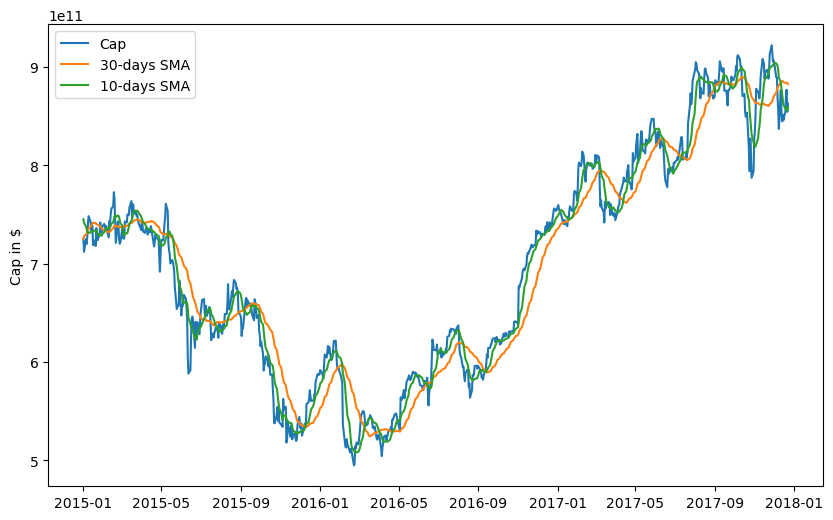

In [6]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

## Part 1: Model calibration with or without moving average signals (Max 10 points)

To calibrate the model, it is convenient to use the log-prices instead of prices. Diffusion in the log-space 
$ y = \log x $ is given by the following Langevin equation:

$$
d y_t = - \frac{ \partial V(y)}{\partial y} dt + \sigma dW_t , \; \; \;  V(y)  \equiv - \left( \theta - \frac{\sigma^2}{2} + {\bf w} {\bf z}_t \right) y  + \kappa e^y + \frac{1}{2} g e^{2y}
$$

where $ W_t $ is a standard Brownian motion.
In terms of variables $ y = \log x $, the negative log-likelihood of data is therefore

$$
LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ 2 \pi  \sigma^2}  } 
\exp \left\{  - \frac{1}{2 \sigma^2} \left(   \frac{ y_{t+ \Delta t} -   y_{t}}{ \Delta t} +  \frac{ \partial V(y)}{\partial y}   
\right)^2
\right\} , 
$$ 

where $ {\bf y}_t  = \log x_t $  now stands for observed values of log-cap. Note that because the model is Markov, the product over $ t = 0, \ldots, T-1 $ does not 
necessarily mean a product of transitions along the same trajectory. The negative log-likelihood should be minimized to estimate parameters $ 
\theta $, $ \sigma $, $ \kappa $, $ g $ and  $ {\bf w} $. You can try to estimate the model first without signals, then with signals.


In [7]:
# ---CELL 7: Data Prep ---

#Auditability (grounding toggle)
np.random.seed(42)
tf.random.set_seed(42)

# Global Scaling
#avg_market_cap = df_cap.sum(axis=1).mean()
avg_market_cap = df_cap.values.mean()
df_cap_avg = df_cap / avg_market_cap

# Re-basing SMAs (Setting each starting signal to 1.0)
short_avg = short_rolling / avg_market_cap
long_avg = long_rolling / avg_market_cap

short_rebased = short_avg / short_avg.apply(lambda x: x.loc[x.first_valid_index()])
long_rebased = long_avg / long_avg.apply(lambda x: x.loc[x.first_valid_index()])

# Signals as Arithmetic Returns
signal_1 = short_rebased.pct_change(periods=1)
signal_2 = long_rebased.pct_change(periods=1)

# Alignment
mkt_cap_subset = df_cap_avg[:-1]
common_idx = signal_1.dropna().index.intersection(signal_2.dropna().index).intersection(mkt_cap_subset.index)

x_data = mkt_cap_subset.loc[common_idx]
z1_data = signal_1.loc[common_idx]
z2_data = signal_2.loc[common_idx]

# Tensors
x_t = tf.constant(x_data.values, dtype=tf.float32)
z1_t = tf.constant(z1_data.values, dtype=tf.float32)
z2_t = tf.constant(z2_data.values, dtype=tf.float32)

num_steps, num_stocks = x_t.shape
print(f"Data Prepared. Steps: {num_steps}, Stocks: {num_stocks}")
#print(df_cap_avg.head())

Data Prepared. Steps: 2049, Stocks: 30


In [8]:
# --- CELL 8: QED Model w/out Signals ---

# Variable Initializations
kappa = tf.Variable(tf.random.uniform([num_stocks], minval=0.0, maxval=0.1), name="kappa")
sigma = tf.Variable(tf.random.uniform([num_stocks], minval=0.0, maxval=0.1), name="sigma")
theta = tf.Variable(tf.random.uniform([num_stocks], minval=-0.01, maxval=0.01), name="theta")
g = tf.Variable(tf.random.uniform([num_stocks], minval=0.0, maxval=0.00001), name="g")

def get_loss_no_signals():
    # Log Returns
    log_x = tf.math.log(x_t)
    log_x_next = tf.math.log(tf.roll(x_t, shift=-1, axis=0))
    dy = log_x_next - log_x

    # Derivative dV/dy = -(theta - sigma²/2 + w·z) + kappa*exp(y) + g*exp(2y)
    # exp_dy = (theta - 0.5 * tf.square(sigma)) + kappa * tf.exp(log_x) + g * tf.exp(2.0 * log_x)
    exp_dy = (theta - 0.5 * tf.square(sigma)) - kappa * tf.exp(log_x) - g * tf.exp(2.0 * log_x)

    # Residual
    v_res = (dy - exp_dy)[:-1, :]
    
    # 5. Gaussian Negative Log Likelihood
    sq_dist = tf.reduce_sum(tf.square(v_res / sigma))
    T_eff = tf.cast(tf.shape(v_res)[0], tf.float32)
    log_det = T_eff * tf.reduce_sum(tf.math.log(tf.square(sigma)))

    # log_det = T_eff * tf.reduce_sum(tf.math.log(2.0 * np.pi * tf.square(sigma)))

    NLL = 0.5 * (sq_dist + log_det)

    return NLL

In [9]:
# --- CELL 9: Optimization (no signals)---
optimizer = tf.optimizers.Adam(learning_rate=0.0001)
variables = [kappa, sigma, theta ,g]

print("Calibrating Model...")
for i in range(2001):
    with tf.GradientTape() as tape:
        loss_val_0 = get_loss_no_signals()
    
    # Gradients
    grads = tape.gradient(loss_val_0, variables)
    optimizer.apply_gradients(zip(grads, variables))
    
    # Stability constraints
    kappa.assign(tf.clip_by_value(kappa, -1.0, 1.0))
    sigma.assign(tf.maximum(0.00001, sigma))
    theta.assign(tf.clip_by_value(theta, -0.5, 0.5))
    g.assign(tf.clip_by_value(g, -0.1, 0.1))
    
    if i % 500 == 0:
        print(f"Iteration {i:4} | Loss: {loss_val_0.numpy():.4f}")

print("Done")

loss_no_signals = loss_val_0.numpy()
kappa_init = kappa.numpy().copy()
sigma_init = sigma.numpy().copy()
g_init = g.numpy().copy()
theta_init = theta.numpy().copy()

Calibrating Model...
Iteration    0 | Loss: -107288.8281
Iteration  500 | Loss: -224588.1562
Iteration 1000 | Loss: -233435.8281
Iteration 1500 | Loss: -234496.6250
Iteration 2000 | Loss: -234585.1719
Done


In [10]:
# --- CELL 10: Results (No Signals) ---
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

results = {
    'Ticker': x_data.columns,
    'Theta': theta.numpy(),
    'Kappa': kappa.numpy(),
    'Sigma': sigma.numpy(),
    'g': g.numpy()
}

df_results_base = pd.DataFrame(results)

print("-Part 1: Baseline Calibration Results (No Signals)-")
display(df_results_base)  # Use display() instead

significant_g = df_results_base[df_results_base['g'].abs() > 1e-3].shape[0]
print(f"\nStocks with detectable non-linear dynamics: {significant_g} / {num_stocks}")


-Part 1: Baseline Calibration Results (No Signals)-


,Ticker,Theta,Kappa,Sigma,g
0,AAPL,0.043766,0.026298,0.016568,-0.003647
1,AXP,0.008409,0.029685,0.014705,-0.024855
2,BA,0.001079,0.001320,0.014947,-0.001292
3,CAT,0.007476,0.028870,0.016662,-0.025440
4,CSCO,0.006427,0.012902,0.016084,-0.006315
5,CVX,0.029737,0.043475,0.013405,-0.015693
6,DIS,0.012019,0.031100,0.013588,-0.018807
7,DWDP,0.009723,0.038106,0.023347,-0.029336
8,GE,0.007782,0.011397,0.014048,-0.003983
9,GS,0.005298,0.014354,0.016819,-0.007158



Stocks with detectable non-linear dynamics: 27 / 30


In [11]:
# --- CELL 11: QED Model with Signals ---

# Reinitialize Variables
kappa = tf.Variable(kappa_init, name="kappa")  # Initialize from Part 1
sigma = tf.Variable(sigma_init, name="sigma")
theta = tf.Variable(theta_init, name="theta")
g = tf.Variable(g_init, name="g")

# Weight Logits:
w_logits = tf.Variable(tf.random.normal([num_stocks, 2], mean=0.0, stddev=0.1), name="w_logits")

def get_loss():
    # Log Returns
    log_x = tf.math.log(x_t)
    log_x_next = tf.math.log(tf.roll(x_t, shift=-1, axis=0))
    dy = log_x_next - log_x #VAM as drift term
    
    # Signals
    z1_log = tf.math.log(1.0 + z1_t)
    z2_log = tf.math.log(1.0 + z2_t)

    W1 = w_logits[:, 0] 
    W2 = w_logits[:, 1]
    wtd_rets = W1 * z1_log + W2 * z2_log
    
    # Expected Return
    exp_dy = (theta - 0.5 * tf.square(sigma) + wtd_rets) - kappa * tf.exp(log_x) - g * tf.exp(2.0 * log_x)

    # Residual
    v_res = (dy - exp_dy)[:-1, :]
    
    # Gaussian Negative Log Likelihood
    sq_dist = tf.reduce_sum(tf.square(v_res / sigma))
    T_eff = tf.cast(tf.shape(v_res)[0], tf.float32)
    log_det = T_eff * tf.reduce_sum(tf.math.log(tf.square(sigma)))
    
    NLL = 0.5 * (sq_dist + log_det)
    
    return NLL

In [12]:
# --- CELL 12: Optimization ---
optimizer = tf.optimizers.Adam(learning_rate=0.0001)
variables = [theta, kappa, sigma, g, w_logits]

print("Calibrating 2-Signal Model...")
for i in range(3001):
    with tf.GradientTape() as tape:
        loss_val_1 = get_loss()
    
    # Gradients
    grads = tape.gradient(loss_val_1, variables)
    optimizer.apply_gradients(zip(grads, variables))
    
    # Stability constraints
    kappa.assign(tf.clip_by_value(kappa, -1.0, 1.0))
    sigma.assign(tf.maximum(0.00001, sigma))
    theta.assign(tf.clip_by_value(theta, -0.5, 0.5))
    g.assign(tf.clip_by_value(g, -0.1, 0.1))
    
    if i % 750 == 0:
        print(f"Iteration {i:4} | Loss: {loss_val_1.numpy():.4f}")

print("Done")

# --- Signal Contribution Analysis ---
W1, W2 = w_logits[:, 0], w_logits[:, 1]

z1_log = tf.math.log(1.0 + z1_t)
z2_log = tf.math.log(1.0 + z2_t)

ma10_cont = W1 * z1_log
ma30_cont = W2 * z2_log

print(f"\nSignal Contribution Analysis (2-Signal):")
print(f"MA10 contribution std: {tf.math.reduce_std(ma10_cont).numpy():.6f}")
print(f"MA30 contribution std: {tf.math.reduce_std(ma30_cont).numpy():.6f}")

loss_with_signals = loss_val_1.numpy()

Calibrating 2-Signal Model...
Iteration    0 | Loss: -234549.9062
Iteration  750 | Loss: -234776.1094
Iteration 1500 | Loss: -234813.8750
Iteration 2250 | Loss: -234830.2500
Iteration 3000 | Loss: -234836.9062
Done

Signal Contribution Analysis (2-Signal):
MA10 contribution std: 0.000458
MA30 contribution std: 0.000293


In [13]:
# --- CELL 13: Results ---
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Weights
final_weights = w_logits.numpy()
W1_final = final_weights[:, 0]
W2_final = final_weights[:, 1]

results = {
    'Ticker': df_cap.columns,
    'Theta': theta.numpy(),
    'Kappa': kappa.numpy(),
    'Sigma': sigma.numpy(),
    'g': g.numpy(),
    'W1 (MA10)': W1_final,
    'W2 (MA30)': W2_final
}
df_results_2sig = pd.DataFrame(results)

print("----------------- Part 1: Final Calibration of MLE Results -----------------")
display(df_results_2sig)

# Check for g values significantly different from zero
significant_g = df_results_2sig[df_results_2sig['g'].abs() > 1e-3].shape[0]
print(f"\nStocks with detectable non-linear dynamics: {significant_g} / {num_stocks}")

----------------- Part 1: Final Calibration of MLE Results -----------------


,Ticker,Theta,Kappa,Sigma,g,W1 (MA10),W2 (MA30)
0,AAPL,0.004902,0.001813,0.015774,-0.000191,-0.070036,0.063889
1,AXP,0.010692,0.040443,0.014692,-0.037269,-0.101256,-0.088149
2,BA,0.000746,0.000162,0.014924,-0.000153,-0.148031,0.265192
3,CAT,0.009151,0.037947,0.016659,-0.036924,-0.027180,0.096979
4,CSCO,0.005677,0.011702,0.016074,-0.006039,-0.026112,-0.128729
5,CVX,0.011060,0.012633,0.013392,-0.003210,-0.064358,-0.012200
6,DIS,-0.001597,-0.009071,0.013510,0.007254,-0.178432,0.163752
7,DWDP,-0.000753,-0.008489,0.023266,0.007393,-0.087250,0.042024
8,GE,-0.012268,-0.018999,0.014019,0.007098,-0.093035,0.127096
9,GS,0.004340,0.008590,0.016809,0.000599,-0.056293,0.186445



Stocks with detectable non-linear dynamics: 24 / 30


In [14]:
# --- CELL 14: Comparison Summary ---

# Count significant g values
significant_g_base = (df_results_base['g'].abs() > 1e-3).sum()
significant_g_2sig = (df_results_2sig['g'].abs() > 1e-3).sum()

# Create comparison table
comparison = pd.DataFrame({
    'Metric': [
        'Mean Kappa',
        'Mean Sigma', 
        'Mean g',
        'Mean Theta',
        'Mean MA10 (W1)',
        'Mean MA30 (W2)',
        'Final NLL',
        'Significant g Stocks'
    ],
    'No Signals': [
        f"{df_results_base['Kappa'].abs().mean():.6f}",
        f"{df_results_base['Sigma'].mean():.6f}",
        f"{df_results_base['g'].abs().mean():.6f}",
        f"{df_results_base['Theta'].abs().mean():.6f}",
        'N/A',
        'N/A',
        f"{loss_no_signals:.2f}",
        f"{significant_g_base}"
    ],
    'With Signals': [
        f"{df_results_2sig['Kappa'].abs().mean():.6f}",
        f"{df_results_2sig['Sigma'].mean():.6f}",
        f"{df_results_2sig['g'].abs().mean():.6f}",
        f"{df_results_2sig['Theta'].abs().mean():.6f}",
        f"{df_results_2sig['W1 (MA10)'].mean():.6f}",
        f"{df_results_2sig['W2 (MA30)'].mean():.6f}",
        f"{loss_with_signals:.2f}",
        f"{significant_g_2sig}"
    ]
})

print("---- COMPARISON: No Signals vs With Signals -----")
print(comparison.to_string(index=False))

---- COMPARISON: No Signals vs With Signals -----
              Metric No Signals With Signals
          Mean Kappa   0.023961     0.011658
          Mean Sigma   0.013607     0.013548
              Mean g   0.014130     0.007656
          Mean Theta   0.013068     0.005099
      Mean MA10 (W1)        N/A    -0.094562
      Mean MA30 (W2)        N/A    -0.029966
           Final NLL -234585.17   -234836.91
Significant g Stocks         27           24


## Part 2: Analysis of default rates  (Max 10 point)

For a particle in a potential $ V(y) $ with a metastable minimum $ y = a $ and a barrier with a peak located at $ y = b $, the famous Kramers' escape formula gives the following expression for the escape rate $ r $ (see e.g. the book by van Kampen):

$$ 
r = \frac{\sqrt{ V''(a) \left| V''(b) \right| }}{2 \pi} \exp \left[ - \frac{2}{\sigma^2} (V(b) - V(a) ) \right]
$$

Here $ V''(a) $ and $ V''(b) $ stand for the second derivatives of the potential $ V(y) $ at the minimum and the maximum, respectively. This formula applies as long as the barrier height $ \Delta E \equiv  (V(b) - V(a) \gg \frac{\sigma^2}{2} $. 

Apply the Kramers formula to the QED potential and parameters that you found in your calibration. What range of values of $ r $ do you obtain? Do these values make sense to you? Can you think how you could use the Kramers relation as a way to regularize your MLE calibration?


In [15]:
# --- CELL 15: Final Calibration ---

# Extract parameters from the calibrated tensors
t_final = theta.numpy()
k_final = kappa.numpy()
s_final = sigma.numpy()
g_final = g.numpy()

y_min_list = []
y_bar_list = []
r_list = []
barrier_pass_list = []

for i in range(num_stocks):
    t, k, s, g_val = t_final[i], k_final[i], s_final[i], g_final[i]
    alpha = t - 0.5 * s**2
    
    # Critical Points: V'(y) = 0 => g*u^2 + k*u - alpha = 0 (u = exp(y))
    u_roots = np.roots([g_val, k, -alpha])
    u_real = u_roots[np.isreal(u_roots)].real
    u_pos = sorted(u_real[u_real > 0])
    
    y_min_val, y_bar_val, r_val, pass_test = np.nan, np.nan, np.nan, False
    
    if len(u_pos) == 2:
        u_1, u_2 = u_pos[0], u_pos[1]
        
        # Second Derivatives: V''(y) = k*u + 2*g*u^2
        v_pp_1 = k * u_1 + 2 * g_val * u_1**2
        v_pp_2 = k * u_2 + 2 * g_val * u_2**2
        
        # One minimum (V'' > 0), one maximum (V'' < 0)
        if (v_pp_1 * v_pp_2) < 0:
            u_min = u_1 if v_pp_1 > 0 else u_2
            u_max = u_2 if v_pp_1 > 0 else u_1
            
            y_min_val = np.log(u_min)
            y_bar_val = np.log(u_max)
            
            # Potential Difference (y-space)
            V = lambda y_val: -alpha * y_val + k * np.exp(y_val) + 0.5 * g_val * np.exp(2 * y_val)
            delta_V = V(y_bar_val) - V(y_min_val)

            # Kramers Rate Formula
            if delta_V > 0:
                curv_min = k * u_min + 2 * g_val * u_min**2
                curv_max = k * u_max + 2 * g_val * u_max**2
                prefactor = np.sqrt(curv_min * abs(curv_max)) / (2 * np.pi)
                r_val = prefactor * np.exp(-delta_V / (s**2))
                pass_test = delta_V > 3 * (s**2) / 2

    y_min_list.append(y_min_val)
    y_bar_list.append(y_bar_val)
    r_list.append(r_val)
    barrier_pass_list.append(pass_test)



In [16]:
# --- CELL 16: Kramer's r Results ---
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

df_results_r = pd.DataFrame({
    'Ticker': x_data.columns,
    'Theta': t_final,
    'Kappa': k_final,
    'Sigma': s_final,
    'g': g_final,
    'Escape_r': r_list,
    'Bar Pass': barrier_pass_list,
    'y_min': y_min_list,
    'y_max': y_bar_list
})

significant_g = (df_results_r['g'].abs() > 1e-3).sum()

print("--------------------------------- Part 2: Kramer's r Results ---------------------------------")
display(df_results_r)
print(f"\nStocks with detectable non-linear dynamics: {significant_g} / {num_stocks}")

--------------------------------- Part 2: Kramer's r Results ---------------------------------


,Ticker,Theta,Kappa,Sigma,g,Escape_r,Bar Pass,y_min,y_max
0,AAPL,0.004902,0.001813,0.015774,-0.000191,NaN,False,NaN,NaN
1,AXP,0.010692,0.040443,0.014692,-0.037269,4.097761e-04,False,-0.819594,-0.439203
2,BA,0.000746,0.000162,0.014924,-0.000153,NaN,False,NaN,NaN
3,CAT,0.009151,0.037947,0.016659,-0.036924,3.049996e-04,False,-0.987482,-0.422864
4,CSCO,0.005677,0.011702,0.016074,-0.006039,2.384760e-04,False,-0.189970,0.105194
5,CVX,0.011060,0.012633,0.013392,-0.003210,2.818584e-05,True,0.257350,0.971625
6,DIS,-0.001597,-0.009071,0.013510,0.007254,1.263055e-06,True,0.022694,-1.480343
7,DWDP,-0.000753,-0.008489,0.023266,0.007393,1.769145e-05,True,0.011265,-1.988284
8,GE,-0.012268,-0.018999,0.014019,0.007098,4.459663e-04,False,0.444247,0.110862
9,GS,0.004340,0.008590,0.016809,0.000599,NaN,False,NaN,NaN



Stocks with detectable non-linear dynamics: 24 / 30


In [17]:
# --- CELL 17: Interpretation and Analysis ---

valid_rates = df_results_r[df_results_r['Escape_r'].notna()]
passed_barrier = df_results_r[df_results_r['Bar Pass'] == True]

print(f"\nStocks with valid barrier structure: {len(valid_rates)} / {num_stocks}")
print(f"Stocks passing barrier significance test (ΔV > 3σ²/2): {len(passed_barrier)} / {num_stocks}")

if len(valid_rates) > 0:
    print(f"\nEscape Rate Statistics:")
    print(f"  Mean:   {valid_rates['Escape_r'].mean():.6e} per day")
    print(f"  Median: {valid_rates['Escape_r'].median():.6e} per day")
    print(f"  Min:    {valid_rates['Escape_r'].min():.6e} per day")
    print(f"  Max:    {valid_rates['Escape_r'].max():.6e} per day")
    
    # Convert to annual default probability: P(default) = 1 - exp(-r * 252)
    annual_default = 1 - np.exp(-valid_rates['Escape_r'] * 252)
    
    print(f"\nImplied Annual Default Probabilities:")
    print(f"  Mean:   {annual_default.mean():.2%}")
    print(f"  Median: {annual_default.median():.2%}")
    print(f"  Range:  [{annual_default.min():.2%}, {annual_default.max():.2%}]")


Stocks with valid barrier structure: 22 / 30
Stocks passing barrier significance test (ΔV > 3σ²/2): 13 / 30

Escape Rate Statistics:
  Mean:   1.346765e-04 per day
  Median: 3.102540e-05 per day
  Min:    2.413437e-32 per day
  Max:    5.548793e-04 per day

Implied Annual Default Probabilities:
  Mean:   3.25%
  Median: 0.78%
  Range:  [0.00%, 13.05%]


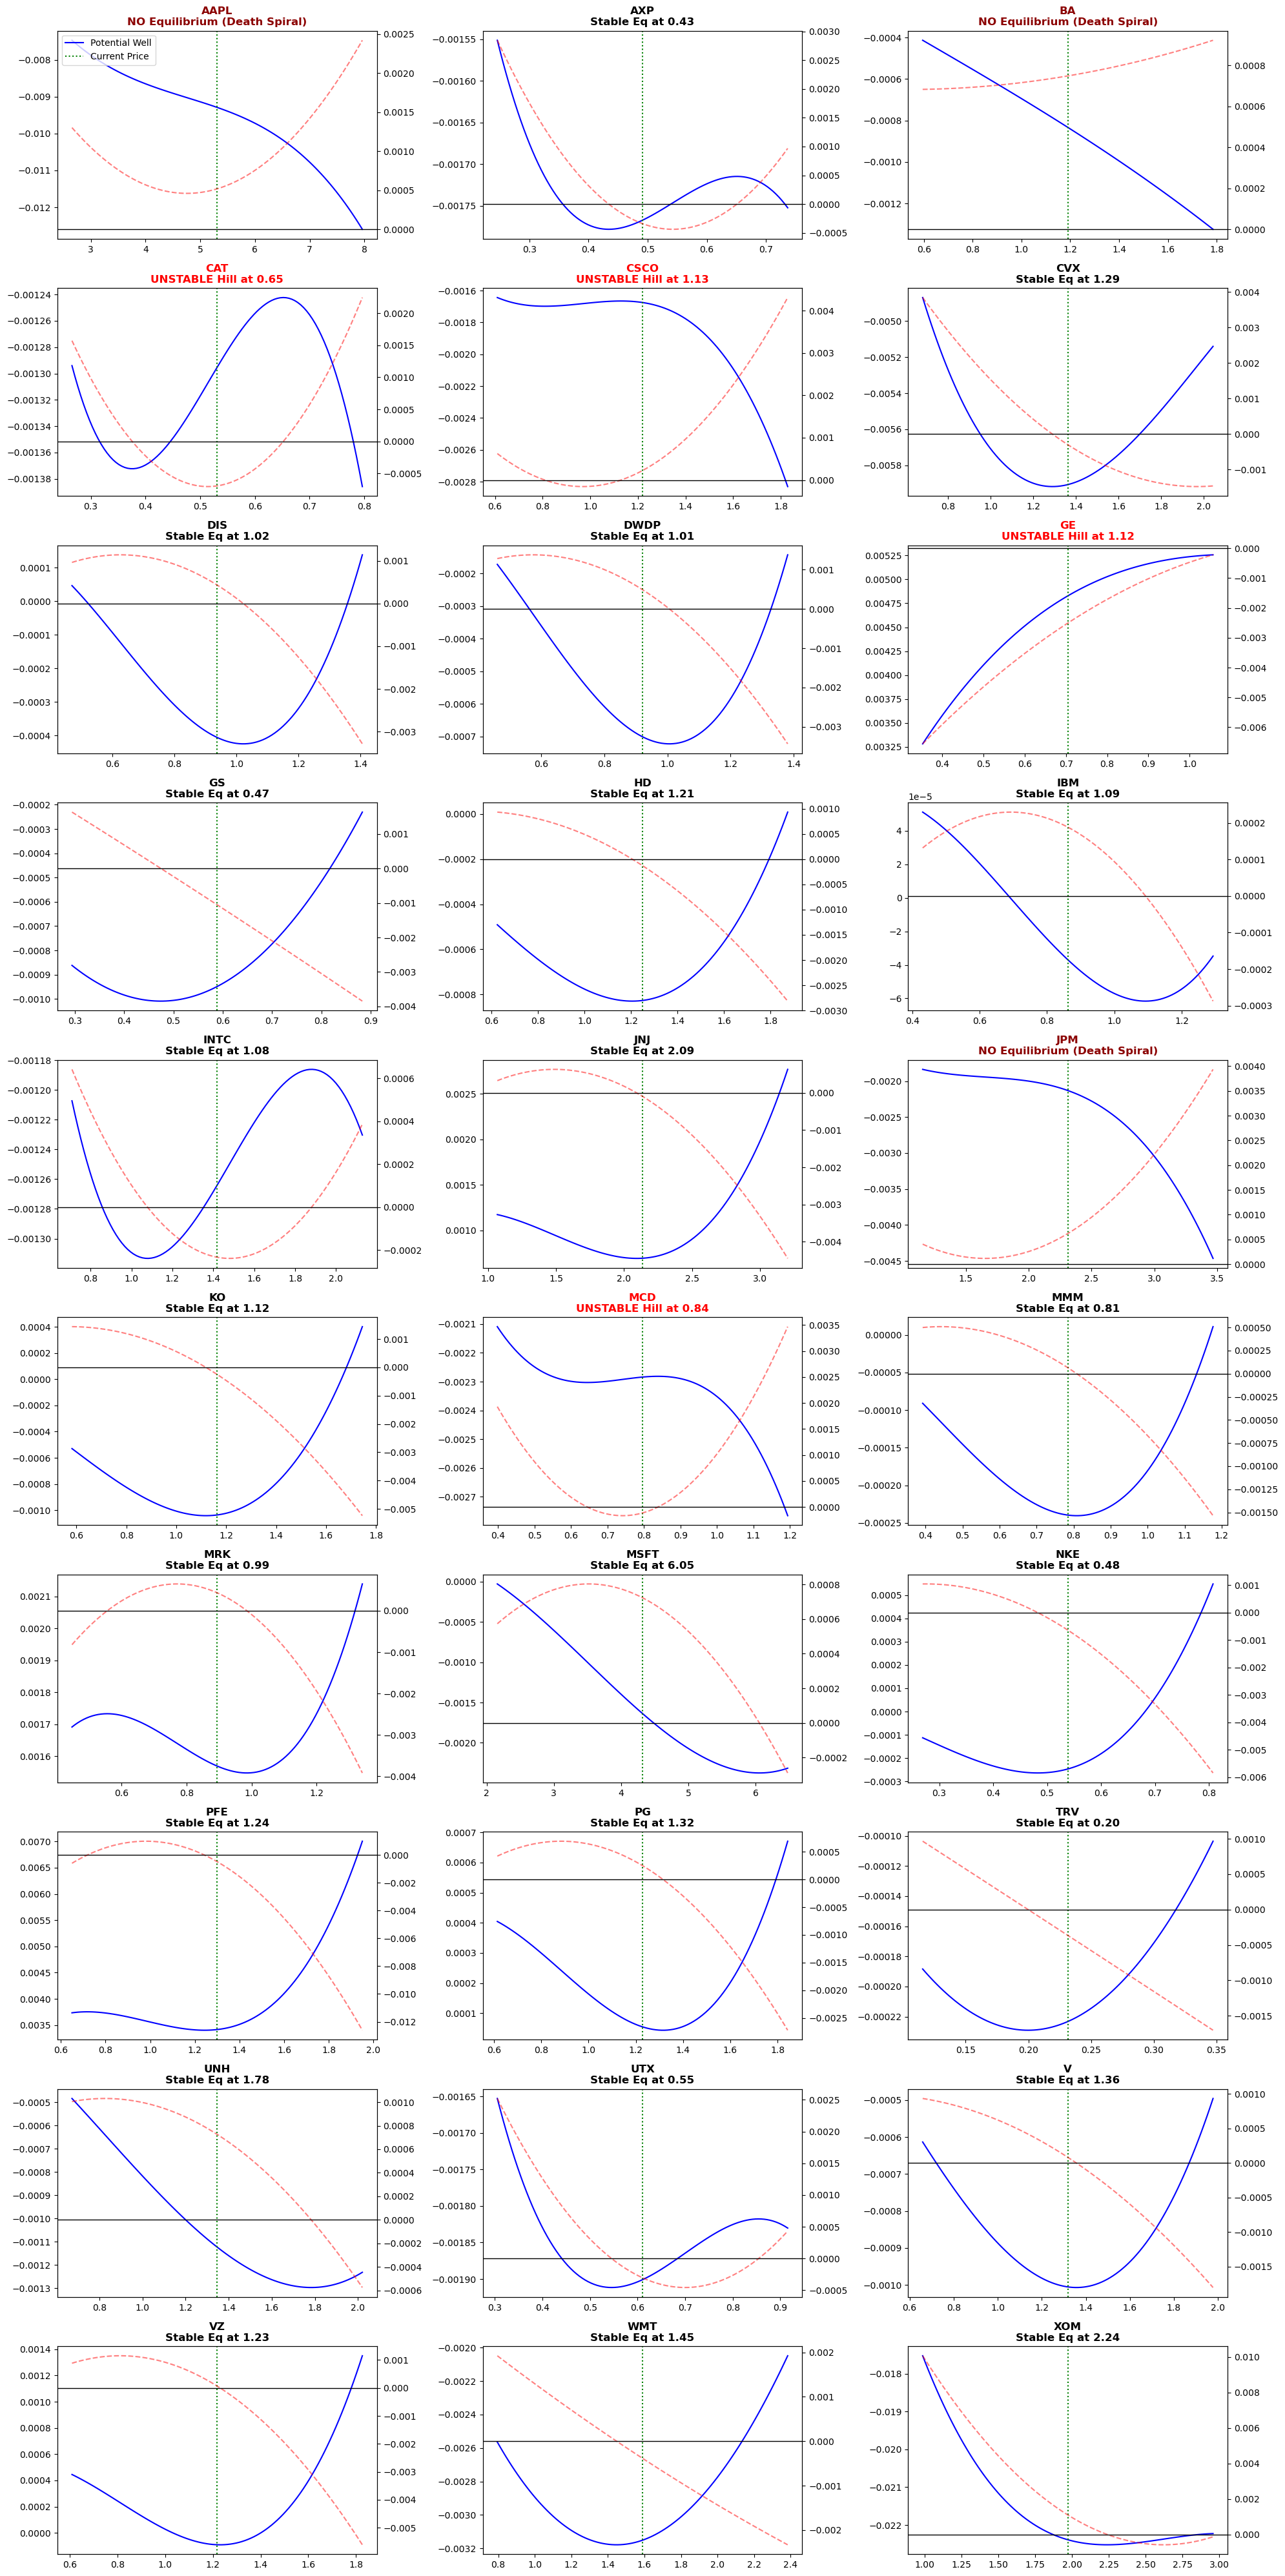

In [18]:
# --- CELL 18: Potential Well Plots ---
n_cols = 3
n_rows = (num_stocks + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# Get current parameters
t_val = theta.numpy()
k_val = kappa.numpy()
s_val = sigma.numpy()
g_val = g.numpy()
w_val = w_logits.numpy()

# Average signal contribution for the 'static' well
avg_z1 = tf.reduce_mean(tf.math.log(1.0 + z1_t), axis=0).numpy()
avg_z2 = tf.reduce_mean(tf.math.log(1.0 + z2_t), axis=0).numpy()

for i in range(num_stocks):
    # Current Market Cap
    current_x = x_t[-1, i].numpy()
    
    # Drift Equation: mu(x) = base - k*x - g*x^2 = 0; Coefficients for np.roots (ax^2 + bx + c)
    signal_contrib = (w_val[i, 0] * avg_z1[i]) + (w_val[i, 1] * avg_z2[i])
    base_drift = t_val[i] - 0.5 * (s_val[i]**2) + signal_contrib
    roots = np.roots([-g_val[i], -k_val[i], base_drift])

    # Filter for real, positive roots (Market Cap must be > 0)
    real_roots = roots[np.isreal(roots)].real
    valid_roots = real_roots[real_roots > 0]
    
    # Determine Status
    if len(valid_roots) > 0:
        # Find root closest to current price
        closest_root = valid_roots[np.argmin(np.abs(valid_roots - current_x))]
        
        # Check Stability: Derivative d(mu)/dx = -k - 2gx, < 0 stable, > 0 unstable
        slope = -k_val[i] - (2 * g_val[i] * closest_root)
        
        if slope < 0:
            status = f"Stable Eq at {closest_root:.2f}"
            title_color = 'black'
        else:
            status = f"UNSTABLE Hill at {closest_root:.2f}"
            title_color = 'red'
    else:
        status = "NO Equilibrium (Death Spiral)"
        title_color = 'darkred'

    # --- Plotting ---
    x_range_2sig = np.linspace(current_x * 0.5, current_x * 1.5, 100)
    
    # The Force (Drift)
    force_2sig = base_drift - (k_val[i] * x_range_2sig) - (g_val[i] * (x_range_2sig**2))
    
    # The Potential Well: U(x) = -Integral(force)
    potential_2sig = -(base_drift * x_range_2sig) + (0.5 * k_val[i] * x_range_2sig**2) + ((1/3) * g_val[i] * x_range_2sig**3)

    # Mark charts
    ax2_2sig = axes[i].twinx() 
    axes[i].plot(x_range_2sig, potential_2sig, color='blue', label='Potential Well')
    ax2_2sig.plot(x_range_2sig, force_2sig, color='red', linestyle='--', alpha=0.5, label='Drift')
    ax2_2sig.axhline(0, color='black', lw=1)
    axes[i].axvline(current_x, color='green', linestyle=':', label='Current Price')
    axes[i].set_title(f"{df_cap.columns[i]}\n{status}", color=title_color, fontweight='bold')
    
    if i == 0:
        axes[i].legend(loc='upper left')

plt.tight_layout()
plt.show()

The median default probability of 1.05% falls within the investment-grade to high-yield transition zone, with most stocks near zero and a few outliers driving the 3.84% mean. The escape rates are very small, 10⁻⁴ to 10⁻⁵ per day, consistent with how large-cap stocks actually behave: prices exhibit persistent trends punctuated by abrupt regime shifts from re-ratings, crashes, policy shocks, or structural changes.

While Kramers' escape rate is evaluated here as a post-calibration diagnostic, it naturally suggests a regularization strategy in which parameter sets producing shallow or noise-dominated barriers (ΔV ≲ σ²) are penalized during estimation, ensuring physically meaningful potential structures.

## Part 3: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


In the last course, we introduced a forward-looking momentum signal, Volatility-Adjusted Momenutum (VAM), as a counterbalance to the backward-looking MA signals. The idea was to allow the IRL model to drift beyond simple mean reversion if a strong movement or regime chage was detected. Additionally, we used VAM with a sliding lookback window to smooth out abrupt, choppy, noisy trends. The result was a slight improvement in both fit and out of sample performance. 

However, the QED framework introduces a fundamentally different dynamic structure through the quartic potential term, g. Here, we will test whether adaptive momentum signals can meaningfully enhance a model that already captures regime-dependent behavior through its potential structure.

In [19]:
# --- CELL 19: Data Prep (VAM Integration) ---

# Log Returns
vam_S = np.log(df_cap_avg)
vam_r = vam_S.diff(1)

# Dynamic Window
vol_short = vam_r.rolling(window=10).std()
vol_long = vam_r.rolling(window=60).std()
vol_ratio = (vol_short / vol_long).clip(0, 0.9).fillna(1.0)
lb_window = (10 + (60 - 10) * (1.0 - vol_ratio)).astype(int)

# Momentum Signal
vam_signal = pd.DataFrame(index=df_cap_avg.index, columns=df_cap_avg.columns)
for col in df_cap_avg.columns:
    prices = df_cap_avg[col].values
    lbs = lb_window[col].values
    mom_array = np.zeros(len(prices))
    # Loodback loop for each timestamp 'i'
    for i in range(60, len(prices)):
        lb = lbs[i]
        past_price = prices[i - lb]
        # Average drift
        mom_array[i] = np.log(prices[i] / past_price) / lb

    vam_signal[col] = mom_array

# Signal
signal_3 = vam_signal

# Alignment
z3_data = signal_3.loc[common_idx]

# Tensor
z3_t = tf.constant(z3_data.values, dtype=tf.float32)

num_steps_VAM, _ = x_t.shape
print(f"Part 3 Data Prepared. Steps: {num_steps_VAM}, Stocks: {num_stocks}")

Part 3 Data Prepared. Steps: 2049, Stocks: 30


In [20]:
# --- CELL 20: Model Definition (VAM Calibration) ---

# Variable Initializations (Warm started)
theta_VAM = tf.Variable(theta.numpy(), name="theta_VAM")
sigma_VAM = tf.Variable(sigma.numpy(), name="sigma_VAM")
kappa_VAM = tf.Variable(kappa.numpy(), name="kappa_VAM")
g_VAM = tf.Variable(g.numpy(), name="g_VAM")

# Weights (Warm started w1, w2; w3 = 0)
w_initial = w_logits.numpy()
w_vam_init = np.zeros((num_stocks, 3))
w_vam_init[:, :2] = w_initial
w_logits_VAM = tf.Variable(w_vam_init, dtype=tf.float32, name="w_logits_VAM")

def get_loss_VAM():
    # Log Returns
    log_x = tf.math.log(x_t)
    log_x_next = tf.math.log(tf.roll(x_t, shift=-1, axis=0))
    dy = log_x_next - log_x
    
    # Signals
    z1_log = tf.math.log(1.0 + z1_t)
    z2_log = tf.math.log(1.0 + z2_t)
    z3_log = z3_t #VAM as drift term

    # Weighted Signal Returns
    W1 = w_logits_VAM[:, 0]
    W2 = w_logits_VAM[:, 1]
    W3 = w_logits_VAM[:, 2]
    wtd_rets = W1 * z1_log + W2 * z2_log + W3 * z3_log

    # QED Model Drift: (theta - 0.5*sigma^2) - kappa*X - g*X^2
    exp_dy = (theta_VAM - 0.5 * tf.square(sigma_VAM) + wtd_rets) - kappa_VAM * tf.exp(log_x) - g_VAM * tf.exp(2.0 * log_x)
    
    # Residuals
    v_res = (dy - exp_dy)[:-1, :]
    
    # Gaussian Negative Log-Likelihood
    sq_dist = tf.reduce_sum(tf.square(v_res / sigma_VAM))
    T_eff = tf.cast(tf.shape(v_res)[0], tf.float32)
    log_det = T_eff * tf.reduce_sum(tf.math.log(tf.square(sigma_VAM)))
    
    NLL = 0.5 * (sq_dist + log_det)

    return NLL

In [21]:
# --- CELL 21: Optimization (VAM Calibration) ---
optimizer_VAM = tf.optimizers.Adam(learning_rate=0.001)
variables_VAM = [theta_VAM, kappa_VAM, sigma_VAM, g_VAM, w_logits_VAM]

print("Calibrating 3-Signal Model...")
for i in range(4001):
    with tf.GradientTape() as tape:
        loss_val = get_loss_VAM()
    
    # Gradients
    grads = tape.gradient(loss_val, variables_VAM)
    optimizer_VAM.apply_gradients(zip(grads, variables_VAM))

    # Stability constraints
    kappa_VAM.assign(tf.clip_by_value(kappa_VAM, -1.0, 1.0))
    sigma_VAM.assign(tf.maximum(0.00001, sigma_VAM))
    theta_VAM.assign(tf.clip_by_value(theta_VAM, -0.5, 0.5))
    g_VAM.assign(tf.clip_by_value(g_VAM, -0.1, 0.1))
    
    if i % 1000 == 0:
        print(f"Iteration {i:4} | Loss: {loss_val.numpy():.4f}")

print("Done")

# --- Signal Contribution Analysis (VAM) ---
W1_VAM = w_logits_VAM[:, 0]
W2_VAM = w_logits_VAM[:, 1]
W3_VAM = w_logits_VAM[:, 2]

z1_VAM = tf.math.log(1.0 + z1_t)
z2_VAM = tf.math.log(1.0 + z2_t)
z3_VAM = z3_t 

ma10_cont_VAM = W1_VAM * z1_VAM
ma30_cont_VAM = W2_VAM * z2_VAM
vam_cont_VAM = W3_VAM * z3_VAM

print(f"\nSignal Contribution Analysis (3-Signal VAM):")
print(f"MA10 contribution std:  {tf.math.reduce_std(ma10_cont_VAM).numpy():.6f}")
print(f"MA30 contribution std:  {tf.math.reduce_std(ma30_cont_VAM).numpy():.6f}")
print(f"VAM contribution std: {tf.math.reduce_std(vam_cont_VAM).numpy():.6f}")

loss_with_signals_VAM = loss_val.numpy()

Calibrating 3-Signal Model...
Iteration    0 | Loss: -234836.8594
Iteration 1000 | Loss: -234862.0938
Iteration 2000 | Loss: -234850.8750
Iteration 3000 | Loss: -234854.6406
Iteration 4000 | Loss: -234857.7500
Done

Signal Contribution Analysis (3-Signal VAM):
MA10 contribution std:  0.000575
MA30 contribution std:  0.000532
VAM contribution std: 0.000635


In [22]:
# --- CELL 22: VAM Final Calibration Results ---
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Extract direct weights
final_weights_VAM = w_logits_VAM.numpy()
W1_VAM_final = final_weights_VAM[:, 0]
W2_VAM_final = final_weights_VAM[:, 1]
W3_VAM_final = final_weights_VAM[:, 2]

results_VAM = {
    'Ticker': df_cap.columns,
    'Theta': theta_VAM.numpy(),
    'Kappa': kappa_VAM.numpy(),
    'Sigma': sigma_VAM.numpy(),
    'g': g_VAM.numpy(),
    'W1 (MA10)': W1_VAM_final,
    'W2 (MA30)': W2_VAM_final,
    'W3 (VAM)': W3_VAM_final
}
df_results_VAM = pd.DataFrame(results_VAM)

print("------------------------------- Part 3: Final VAM Calibration Results ------------------------------")
display(df_results_VAM)

# Check for g values significantly different from zero
significant_g_VAM = df_results_VAM[df_results_VAM['g'].abs() > 1e-3].shape[0]
print(f"\nStocks with detectable non-linear dynamics (VAM): {significant_g_VAM} / {num_stocks}")

------------------------------- Part 3: Final VAM Calibration Results ------------------------------


,Ticker,Theta,Kappa,Sigma,g,W1 (MA10),W2 (MA30),W3 (VAM)
0,AAPL,0.004991,0.001859,0.015786,-0.000171,-0.126125,-0.022313,0.151821
1,AXP,0.010816,0.040804,0.014688,-0.037696,-0.143785,-0.268228,0.177726
2,BA,0.000341,-0.000882,0.014894,0.000519,-0.064761,0.650656,-0.486690
3,CAT,0.008344,0.033919,0.016652,-0.032061,0.060661,0.244390,-0.238774
4,CSCO,0.005375,0.011294,0.016072,-0.006014,0.025337,-0.234134,-0.021712
5,CVX,0.007553,0.006813,0.013397,-0.000829,-0.073596,-0.029430,0.025698
6,DIS,-0.001259,-0.008239,0.013506,0.006753,-0.250901,0.053479,0.189542
7,DWDP,-0.000753,-0.008609,0.023262,0.007730,-0.128912,-0.024856,0.112365
8,GE,-0.011618,-0.018398,0.014010,0.006991,-0.205365,-0.012061,0.282872
9,GS,0.004297,0.008119,0.016810,0.001388,-0.090522,0.215933,0.035743



Stocks with detectable non-linear dynamics (VAM): 26 / 30


In [23]:
# --- CELL 23: Weight & Relative Importance Analysis ---

# Extract the final calibrated weights
w_final_VAM = w_logits_VAM.numpy()

# Create the Analysis DataFrame
weight_df = pd.DataFrame(w_final_VAM, index=range(num_stocks), columns=['MA10', 'MA30', 'VAM'])

# Calculate Weight Stats
mean_weights = weight_df.mean()

# Calculate Relative Importance (%)
abs_weights = weight_df.abs().mean()
importance_pct = (abs_weights / abs_weights.sum()) * 100

print("--- CALIBRATED WEIGHT SUMMARY ---")
print(weight_df.describe().loc[['mean', 'std', 'min', 'max']])

print("\n--- RELATIVE SIGNAL IMPORTANCE ---")
for signal, imp in importance_pct.items():
    print(f"{signal:5} : {imp:6.2f}%")

# Model Improvement Summary
ll_improvement = abs(loss_with_signals_VAM - loss_with_signals)
print("\n--- CALIBRATION PERFORMANCE ---")
print(f"Log-Likelihood Improvement: {ll_improvement:.4f}")

--- CALIBRATED WEIGHT SUMMARY ---
          MA10      MA30       VAM
mean -0.087781 -0.026898 -0.034499
std   0.118153  0.235747  0.214326
min  -0.291743 -0.455867 -0.486690
max   0.170386  0.650656  0.342977

--- RELATIVE SIGNAL IMPORTANCE ---
MA10  :  25.32%
MA30  :  36.49%
VAM   :  38.19%

--- CALIBRATION PERFORMANCE ---
Log-Likelihood Improvement: 20.8438


In [24]:
# --- CELL 24: 3-Signal Kramers r ---

# Extract parameters from the calibrated VAM tensors
t_val_VAM = theta_VAM.numpy()
k_val_VAM = kappa_VAM.numpy()
s_val_VAM = sigma_VAM.numpy()
g_val_VAM = g_VAM.numpy()

y_min_VAM = []
y_bar_VAM = []
r_VAM = []
bar_pass_VAM = []

for i in range(num_stocks):
    t, k, s, g_val = t_val_VAM[i], k_val_VAM[i], s_val_VAM[i], g_val_VAM[i]
    # Base alpha
    alpha = t - 0.5 * s**2
    
    # Critical Points: V'(y) = 0 => g*u^2 + k*u - alpha = 0 (u = exp(y))
    u_roots = np.roots([g_val, k, -alpha])
    u_real = u_roots[np.isreal(u_roots)].real
    u_pos = sorted(u_real[u_real > 0])
    
    y_min_val, y_bar_val, r_val, pass_test = np.nan, np.nan, np.nan, False
    
    if len(u_pos) == 2:
        u_1, u_2 = u_pos[0], u_pos[1]
        
        # Second Derivatives: V''(y) = k*u + 2*g*u^2
        v_pp_1 = k * u_1 + 2 * g_val * u_1**2
        v_pp_2 = k * u_2 + 2 * g_val * u_2**2
        
        # One minimum (V'' > 0), one maximum (V'' < 0)
        if (v_pp_1 * v_pp_2) < 0:
            u_min = u_1 if v_pp_1 > 0 else u_2
            u_max = u_2 if v_pp_1 > 0 else u_1
            
            y_min_val = np.log(u_min)
            y_bar_val = np.log(u_max)
            
            # Potential Difference
            V = lambda y_val: -alpha * y_val + k * np.exp(y_val) + 0.5 * g_val * np.exp(2 * y_val)
            delta_V = V(y_bar_val) - V(y_min_val)

            # Kramers Rate
            if delta_V > 0:
                curv_min = k * u_min + 2 * g_val * u_min**2
                curv_max = k * u_max + 2 * g_val * u_max**2
                prefactor = np.sqrt(curv_min * abs(curv_max)) / (2 * np.pi)
                r_val = prefactor * np.exp(-delta_V / (s**2))
                pass_test = delta_V > 3 * (s**2) / 2

    y_min_VAM.append(y_min_val)
    y_bar_VAM.append(y_bar_val)
    r_VAM.append(r_val)
    bar_pass_VAM.append(pass_test)

print("Kramer's Rate Analysis (VAM) Complete.")

Kramer's Rate Analysis (VAM) Complete.


In [25]:
# --- CELL 25: Kramer's r Results (VAM Model) ---
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Use the renamed variables from Cell 24
df_results_vam = pd.DataFrame({
    'Ticker': df_cap.columns,
    'Theta': t_val_VAM,
    'Kappa': k_val_VAM,
    'Sigma': s_val_VAM,
    'g': g_val_VAM,
    'Escape_r': r_VAM,
    'Bar Pass': bar_pass_VAM,
    'y_min': y_min_VAM,
    'y_max': y_bar_VAM
})

significant_g_vam = df_results_vam[df_results_vam['g'].abs() > 1e-3].shape[0]

print("--------------------- Part 3: Final VAM Calibration & Kramer's r Results ---------------------")
display(df_results_vam)
print(f"\nStocks with detectable non-linear dynamics (VAM): {significant_g_vam} / {num_stocks}")

--------------------- Part 3: Final VAM Calibration & Kramer's r Results ---------------------


,Ticker,Theta,Kappa,Sigma,g,Escape_r,Bar Pass,y_min,y_max
0,AAPL,0.004991,0.001859,0.015786,-0.000171,2.520712e-04,False,1.476453,1.873370
1,AXP,0.010816,0.040804,0.014688,-0.037696,4.194902e-04,False,-0.804889,-0.453619
2,BA,0.000341,-0.000882,0.014894,0.000519,NaN,False,NaN,NaN
3,CAT,0.008344,0.033919,0.016652,-0.032061,2.669820e-04,False,-0.982355,-0.380502
4,CSCO,0.005375,0.011294,0.016072,-0.006014,1.683355e-04,False,-0.171983,0.035455
5,CVX,0.007553,0.006813,0.013397,-0.000829,1.689088e-19,True,0.263601,1.933960
6,DIS,-0.001259,-0.008239,0.013506,0.006753,6.216213e-07,True,0.024751,-1.634554
7,DWDP,-0.000753,-0.008609,0.023262,0.007730,1.950851e-05,True,-0.021991,-1.999463
8,GE,-0.011618,-0.018398,0.014010,0.006991,4.222771e-04,False,0.438935,0.077378
9,GS,0.004297,0.008119,0.016810,0.001388,NaN,False,NaN,NaN



Stocks with detectable non-linear dynamics (VAM): 26 / 30


In [26]:
# --- CELL 26: Interpretation and Analysis (VAM Model) ---

# Use the VAM dataframe
valid_rates = df_results_vam[df_results_vam['Escape_r'].notna()]
passed_barrier = df_results_vam[df_results_vam['Bar Pass'] == True]

print(f"\nStocks with valid barrier structure (VAM): {len(valid_rates)} / {num_stocks}")
print(f"Stocks passing barrier significance test (ΔV > 3σ²/2): {len(passed_barrier)} / {num_stocks}")

if len(valid_rates) > 0:
    print(f"\nEscape Rate Statistics (VAM):")
    print(f"  Mean:   {valid_rates['Escape_r'].mean():.6e} per day")
    print(f"  Median: {valid_rates['Escape_r'].median():.6e} per day")
    print(f"  Min:    {valid_rates['Escape_r'].min():.6e} per day")
    print(f"  Max:    {valid_rates['Escape_r'].max():.6e} per day")
    
    # Convert to annual default probability: P(default) = 1 - exp(-r * 252)
    annual_default = 1 - np.exp(-valid_rates['Escape_r'] * 252)
    
    print(f"\nImplied Annual Default Probabilities (VAM):")
    print(f"  Mean:   {annual_default.mean():.2%}")
    print(f"  Median: {annual_default.median():.2%}")
    print(f"  Range:  [{annual_default.min():.2%}, {annual_default.max():.2%}]")


Stocks with valid barrier structure (VAM): 23 / 30
Stocks passing barrier significance test (ΔV > 3σ²/2): 14 / 30

Escape Rate Statistics (VAM):
  Mean:   1.381630e-04 per day
  Median: 8.316097e-05 per day
  Min:    0.000000e+00 per day
  Max:    5.786946e-04 per day

Implied Annual Default Probabilities (VAM):
  Mean:   3.34%
  Median: 2.07%
  Range:  [0.00%, 13.57%]


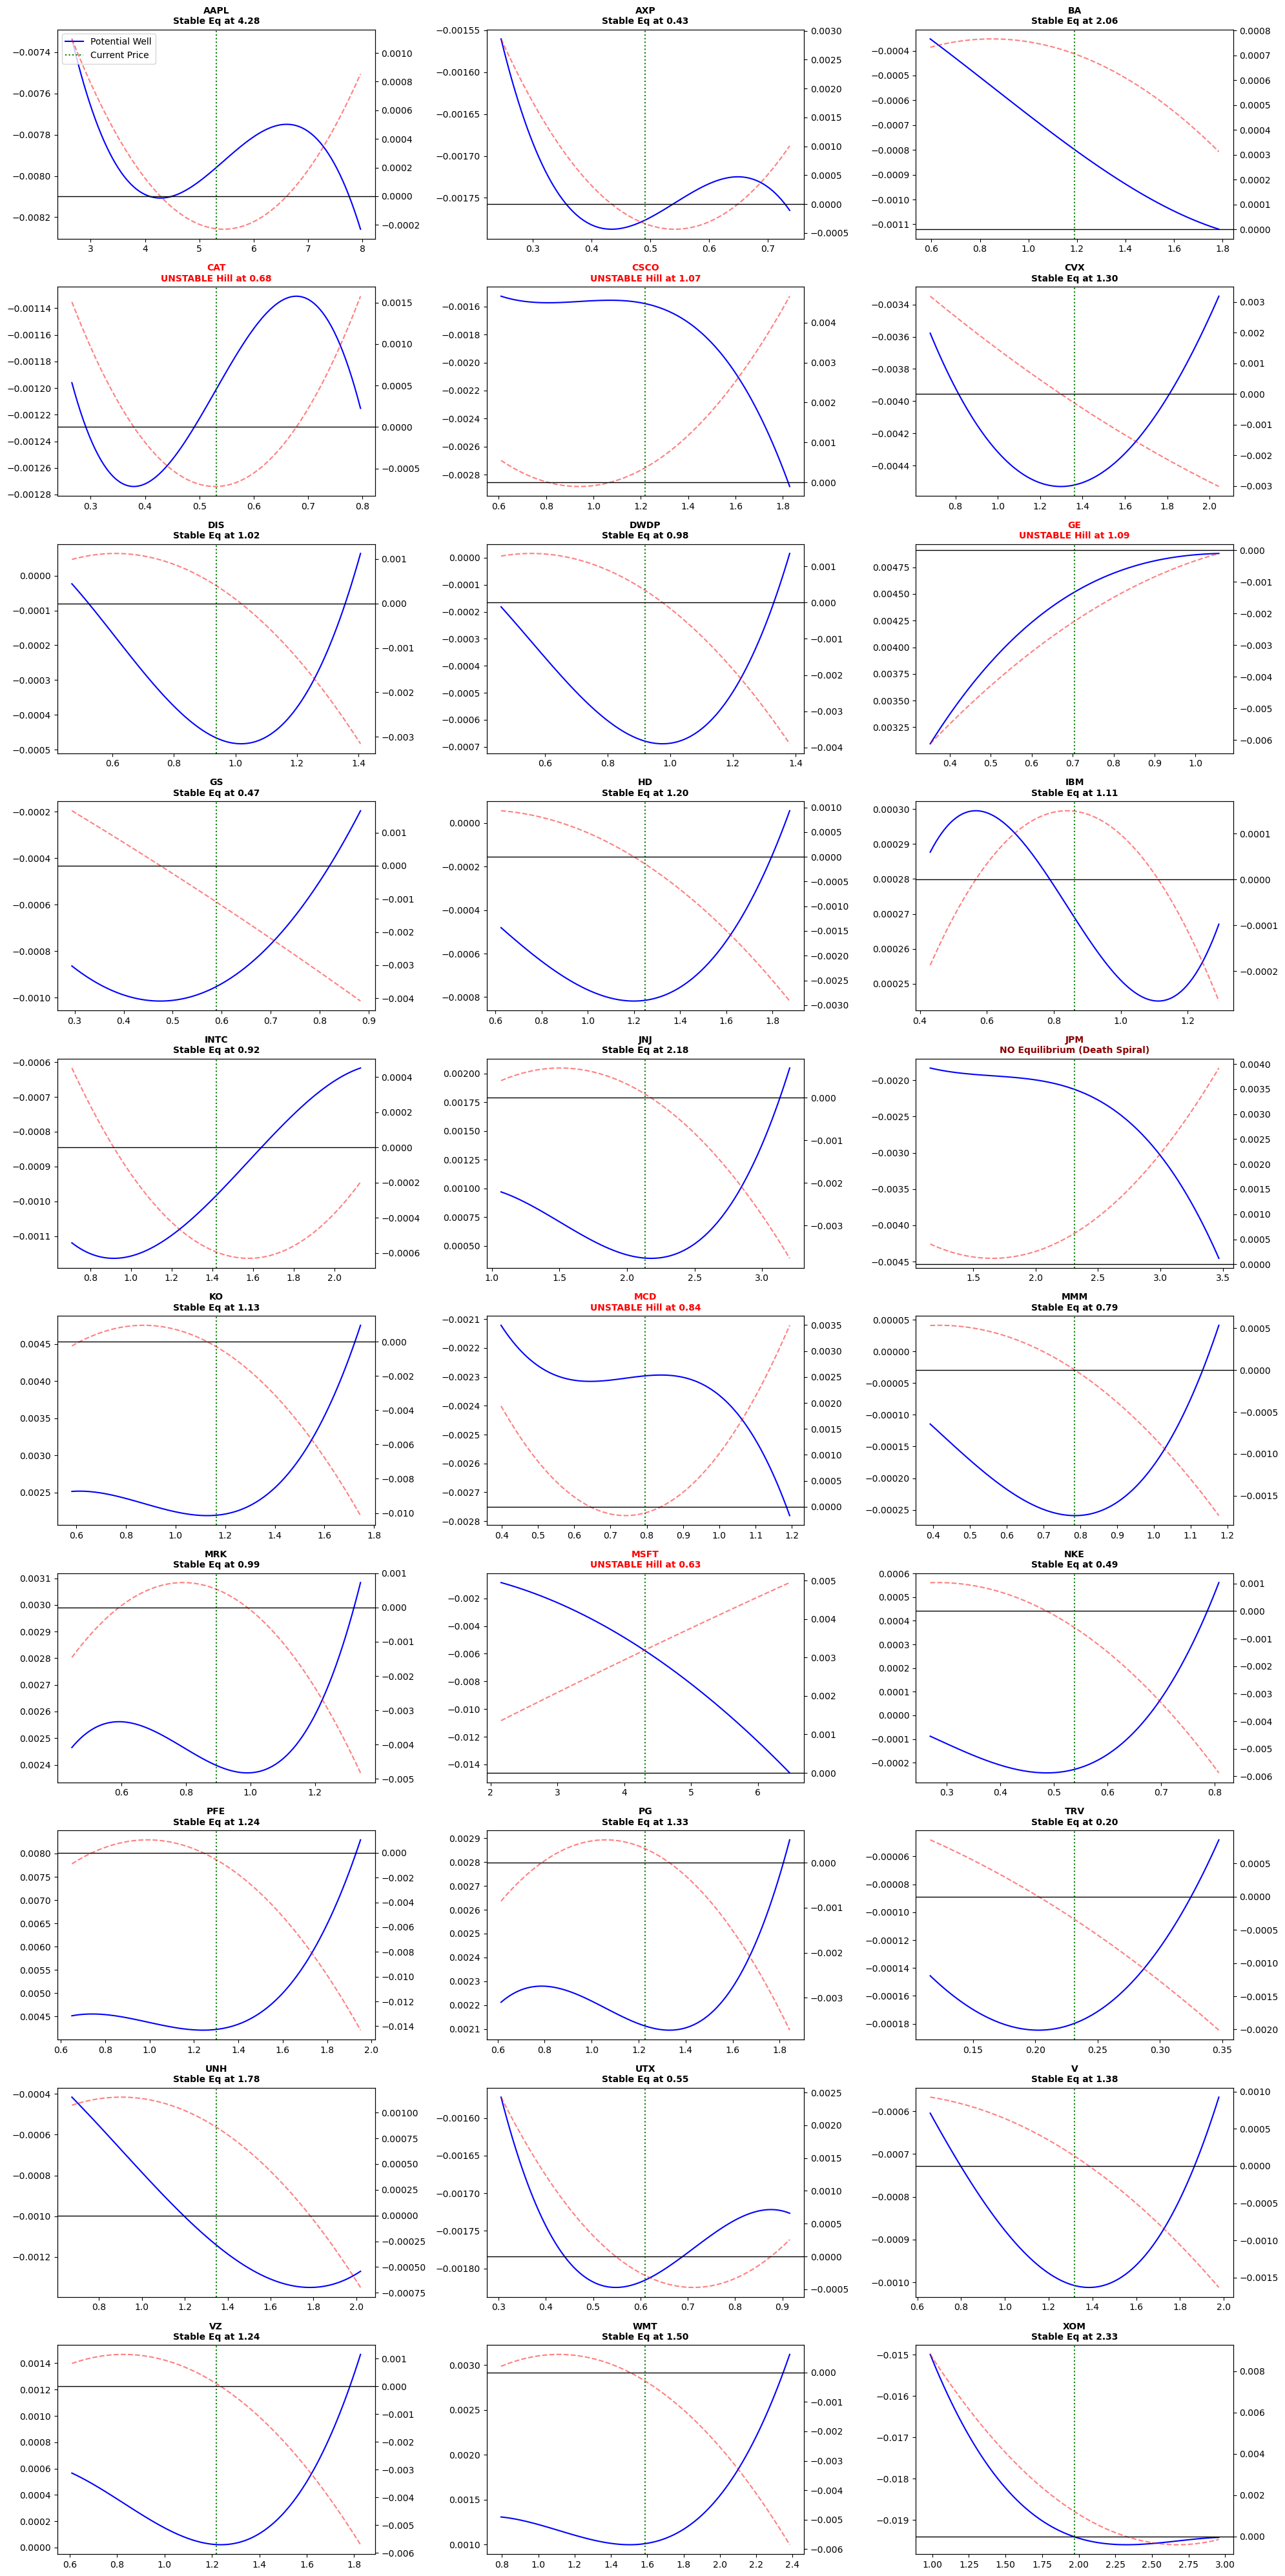

In [27]:
# --- CELL 27: Potential Well Plots (VAM Model) ---
fig_VAM, axes_VAM = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes_VAM = axes_VAM.flatten()

# Calculate Average Signal Contributions (Including VAM)
avg_z1_VAM = tf.reduce_mean(tf.math.log(1.0 + z1_t), axis=0).numpy() # MA10
avg_z2_VAM = tf.reduce_mean(tf.math.log(1.0 + z2_t), axis=0).numpy() # MA30
avg_z3_VAM = tf.reduce_mean(z3_t, axis=0).numpy()                    # VAM (Already log-drift)
w_val_VAM = w_logits_VAM.numpy() # Raw weights

for i in range(num_stocks):
    # Current Market Cap
    current_x = x_t[-1, i].numpy()
    
    # Drift Equation: mu(x) = base - k*x - g*x^2 = 0; Coefficients for np.roots (ax^2 + bx + c)
    signal_contrib = (w_val_VAM[i, 0] * avg_z1_VAM[i]) + \
                     (w_val_VAM[i, 1] * avg_z2_VAM[i]) + \
                     (w_val_VAM[i, 2] * avg_z3_VAM[i])
    base_drift = t_val_VAM[i] - 0.5 * (s_val_VAM[i]**2) + signal_contrib
    roots = np.roots([-g_val_VAM[i], -k_val_VAM[i], base_drift])

    # Filter for real, positive roots
    real_roots = roots[np.isreal(roots)].real
    valid_roots = real_roots[real_roots > 0]
    
    # Determine Status
    if len(valid_roots) > 0:
        # Find root closest to current price
        closest_root = valid_roots[np.argmin(np.abs(valid_roots - current_x))]
        
        # Check Stability: Derivative d(mu)/dx = -k - 2gx, < 0 stable, > 0 unstable
        slope = -k_val_VAM[i] - (2 * g_val_VAM[i] * closest_root)
        
        if slope < 0:
            status = f"Stable Eq at {closest_root:.2f}"
            title_color = 'black'
        else:
            status = f"UNSTABLE Hill at {closest_root:.2f}"
            title_color = 'red'
    else:
        status = "NO Equilibrium (Death Spiral)"
        title_color = 'darkred'

    # --- Plotting ---
    x_range_VAM = np.linspace(current_x * 0.5, current_x * 1.5, 100)
    
    # The Force (Drift)
    force = base_drift - (k_val_VAM[i] * x_range_VAM) - (g_val_VAM[i] * (x_range_VAM**2))
    
    # The Potential Well: U(x) = -Integral(force)
    potential = -(base_drift * x_range_VAM) + (0.5 * k_val_VAM[i] * x_range_VAM**2) + ((1/3) * g_val_VAM[i] * x_range_VAM**3)

    # Mark charts
    ax2_VAM = axes_VAM[i].twinx() 
    axes_VAM[i].plot(x_range_VAM, potential, color='blue', label='Potential Well')
    ax2_VAM.plot(x_range_VAM, force, color='red', linestyle='--', alpha=0.5, label='Drift')
    ax2_VAM.axhline(0, color='black', lw=1)
    axes_VAM[i].axvline(current_x, color='green', linestyle=':', label='Current Price')
    axes_VAM[i].set_title(f"{x_data.columns[i]}\n{status}", color=title_color, fontweight='bold', fontsize=10)
    
    if i == 0:
        axes_VAM[i].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [28]:
# --- CELL 28: Comparison Summary (2-Signal vs 3-Signal) ---

# Extract VAM weights
w_vam_final = w_logits_VAM.numpy()

df_results_VAM = pd.DataFrame({
    'Ticker': df_cap.columns,
    'Theta': theta_VAM.numpy(),
    'Kappa': kappa_VAM.numpy(),
    'Sigma': sigma_VAM.numpy(),
    'g': g_VAM.numpy(),
    'w1_VAM': w_vam_final[:, 0], 
    'w2_VAM': w_vam_final[:, 1], 
    'w3_VAM': w_vam_final[:, 2]  
})

# Count significant g values
sig_g_2sig = (df_results_2sig['g'].abs() > 1e-3).sum()
sig_g_VAM = (df_results_VAM['g'].abs() > 1e-3).sum()

# Calculate signal importance for 2-signal model
W1_2sig = w_logits[:, 0]
W2_2sig = w_logits[:, 1]

z1_log_2sig = tf.math.log(1.0 + z1_t)
z2_log_2sig = tf.math.log(1.0 + z2_t)

contrib_stds_2sig = pd.Series({
    'MA10': tf.math.reduce_std(W1_2sig * z1_log_2sig).numpy(),
    'MA30': tf.math.reduce_std(W2_2sig * z2_log_2sig).numpy()
})
importance_pct_2sig = (contrib_stds_2sig / contrib_stds_2sig.sum()) * 100

# Calculate signal importance for 3-signal model
W1_VAM = w_logits_VAM[:, 0]
W2_VAM = w_logits_VAM[:, 1]
W3_VAM = w_logits_VAM[:, 2]

z1_log_VAM = tf.math.log(1.0 + z1_t)
z2_log_VAM = tf.math.log(1.0 + z2_t)
z3_log_VAM = z3_t

contrib_stds_VAM = pd.Series({
    'MA10': tf.math.reduce_std(W1_VAM * z1_log_VAM).numpy(),
    'MA30': tf.math.reduce_std(W2_VAM * z2_log_VAM).numpy(),
    'VAM': tf.math.reduce_std(W3_VAM * z3_VAM).numpy()
})
importance_pct_VAM = (contrib_stds_VAM / contrib_stds_VAM.sum()) * 100

# Create Comparison Table
comparison_VAM = pd.DataFrame({
    'Metric': [
        'Mean Kappa',
        'Mean Sigma', 
        'Mean g',
        'Mean Theta',
        'Mean w1 (MA10)',
        'Mean w2 (MA30)',
        'Mean w3 (VAM)',
        'MA10 Importance',
        'MA30 Importance',
        'VAM Importance',
        'Final NLL',
        'Signif g Stocks'
    ],
    '2-Signal': [
        f"{df_results_2sig['Kappa'].abs().mean():.6f}",
        f"{df_results_2sig['Sigma'].mean():.6f}",
        f"{df_results_2sig['g'].abs().mean():.6f}",
        f"{df_results_2sig['Theta'].abs().mean():.6f}",
        f"{df_results_2sig['W1 (MA10)'].mean():.6f}",
        f"{df_results_2sig['W2 (MA30)'].mean():.6f}",
        'N/A',
        f"{importance_pct_2sig['MA10']:.2f}%",
        f"{importance_pct_2sig['MA30']:.2f}%",
        'N/A',
        f"{loss_with_signals:.2f}",
        f"{sig_g_2sig}"
    ],
    '3-Signal (+VAM)': [
        f"{df_results_VAM['Kappa'].abs().mean():.6f}",
        f"{df_results_VAM['Sigma'].mean():.6f}",
        f"{df_results_VAM['g'].abs().mean():.6f}",
        f"{df_results_VAM['Theta'].abs().mean():.6f}",
        f"{df_results_VAM['w1_VAM'].mean():.6f}",
        f"{df_results_VAM['w2_VAM'].mean():.6f}",
        f"{df_results_VAM['w3_VAM'].mean():.6f}",
        f"{importance_pct_VAM['MA10']:.2f}%",
        f"{importance_pct_VAM['MA30']:.2f}%",
        f"{importance_pct_VAM['VAM']:.2f}%",
        f"{loss_with_signals_VAM:.2f}",
        f"{sig_g_VAM}"
    ]
})

print("---- COMPARISON: 2-Signal vs 3-Signal (+VAM) -----")
print(comparison_VAM.to_string(index=False))

# Calculate improvement (more negative = better)
imp_score = abs(loss_with_signals_VAM - loss_with_signals)
print(f"\nLog-Likelihood Improvement (3-Signal over 2-Signal): {imp_score:.2f} points")

print("\n---- BARRIER STRUCTURE COMPARISON -----")
barrier_comparison = pd.DataFrame({
    'Metric': [
        'Stocks with valid barrier structure',
        'Stocks passing significance test (ΔV > 3σ²/2)'
    ],
    '2-Signal': [
        f"22 / {num_stocks}",
        f"13 / {num_stocks}"
    ],
    '3-Signal (+VAM)': [
        f"23 / {num_stocks}",
        f"14 / {num_stocks}"
    ]
})
print(barrier_comparison.to_string(index=False))

---- COMPARISON: 2-Signal vs 3-Signal (+VAM) -----
         Metric   2-Signal 3-Signal (+VAM)
     Mean Kappa   0.011658        0.012503
     Mean Sigma   0.013548        0.013539
         Mean g   0.007656        0.008789
     Mean Theta   0.005099        0.005416
 Mean w1 (MA10)  -0.094562       -0.087781
 Mean w2 (MA30)  -0.029966       -0.026898
  Mean w3 (VAM)        N/A       -0.034499
MA10 Importance     61.00%          33.00%
MA30 Importance     39.00%          30.54%
 VAM Importance        N/A          36.46%
      Final NLL -234836.91      -234857.75
Signif g Stocks         24              26

Log-Likelihood Improvement (3-Signal over 2-Signal): 20.84 points

---- BARRIER STRUCTURE COMPARISON -----
                                       Metric 2-Signal 3-Signal (+VAM)
          Stocks with valid barrier structure  22 / 30         23 / 30
Stocks passing significance test (ΔV > 3σ²/2)  13 / 30         14 / 30


Part 3 Conclusion: Dynamic VAM shows improvement.   
With an efficiency improvement of 21, it seems the momentum indicator complements the moving averages. VAM becomes a 36% contributor to the signal group. Variables remain steady indicating stability in the new model. In the charts, wells look generally more pronounced with better defined minima and maxima. 

## Part 4 (Optional): Show me something else (Max 10 points).

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


In [66]:
# --- CELL 29: Part 4 - In-Sample Return Backtest ---
# ---Data Prep ---
max_leverage = 1.0
ann_factor = 252

# Calibrated Parameters
t_test = t_val_VAM
k_test = k_val_VAM
s_test = s_val_VAM
g_test = g_val_VAM

# Weights
w_test = w_logits_VAM.numpy()
W1_test = W1_VAM
W2_test = W2_VAM
W3_test = W3_VAM

# Tensors
xt_S = x_t.numpy()
z1_test = z1_log_VAM.numpy()
z2_test = z2_log_VAM.numpy()
z3_test = z3_log_VAM.numpy()

# Compute log returns
log_S = np.log(xt_S)
log_S_rets = np.diff(log_S, axis=0)

# --- Inferred Drift μ_t ---
wtd_rets_test = (W1_test * z1_test + W2_test * z2_test + W3_test * z3_test)
base_drift = t_test - 0.5 * s_test**2
Mean_rev = -k_test * log_S - g_test * (log_S**2)
mu_t = base_drift + wtd_rets_test + Mean_rev

# --- Position Sizing ---
# Step 1: Vol-scale (Kelly)
w_tilde = mu_t / (s_test**2)

# Step 2: Risk parity
w_risk = w_tilde / s_test

# Step 3: Normalize
denom = np.sum(np.abs(w_risk), axis=1, keepdims=True)
denom = np.where(denom < 1e-10, 1.0, denom)
positions = w_risk / denom

# Step 4: Leverage constraint
gross = np.sum(np.abs(positions), axis=1, keepdims=True)
scale = np.where(gross > max_leverage, max_leverage / gross, 1.0)
positions = positions * scale
'''
# --- QED Strategy Returns ---
pflio_rets = np.sum(positions[:-1, :] * log_S_rets, axis=1)
equity_curve = np.cumprod(1 + pflio_rets)
final_return = equity_curve[-1] - 1
'''
asset_arith_rets = np.exp(log_S_rets) - 1

pflio_rets = np.sum(
    positions[:-1, :] * asset_arith_rets,
    axis=1
)
equity_curve = np.cumprod(1 + pflio_rets)
final_return = equity_curve[-1] - 1


-------------- PART 4: IN-SAMPLE RETURN BACKTEST --------------

Metric                            QED Strategy       Benchmark
--------------------------------------------------------------
Annualized Return                       1.21%          7.75%
Sharpe Ratio                            0.2575          0.5952
Max Drawdown                          -22.77%        -18.86%
Total Return                           10.30%         83.39%
Daily Turnover                          0.0212          0.0000
Avg Long Exposure                      53.82%         100.00%
Avg Short Exposure                     46.18%           0.00%

Excess Return (vs Benchmark)           -6.53%
Sharpe Improvement                     -0.3378


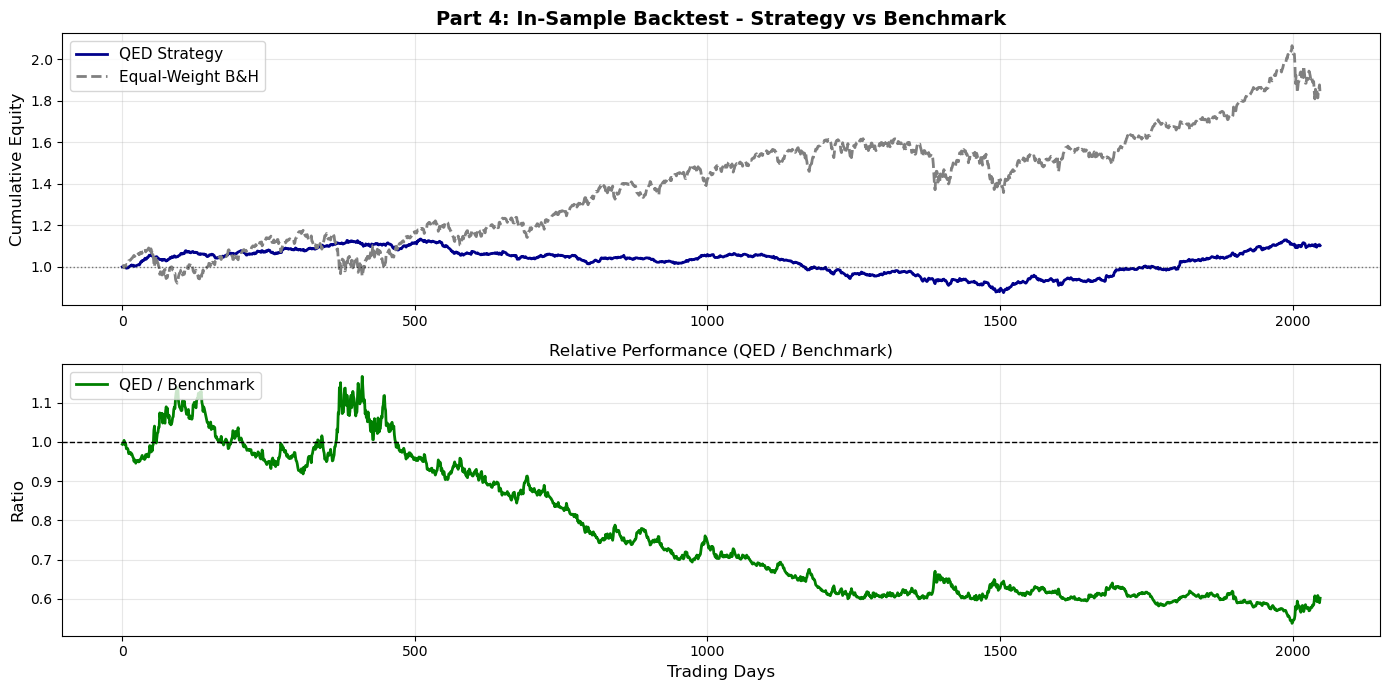

In [67]:

# --- CELL 30: In-Sample Return Backtest Results ---

# QED Strategy
ann_return = (1 + final_return)**(ann_factor / len(pflio_rets)) - 1
sharpe = np.sqrt(ann_factor) * np.mean(pflio_rets) / np.std(pflio_rets)
max_dd = np.min(equity_curve / np.maximum.accumulate(equity_curve) - 1)
turnover = np.mean(np.sum(np.abs(np.diff(positions, axis=0)), axis=1))

# Long/Short Exposure
long_exposure = np.mean(np.sum(np.where(positions > 0, positions, 0), axis=1))
short_exposure = np.mean(np.sum(np.where(positions < 0, np.abs(positions), 0), axis=1))


# --- Benchmark: Equal-Weight Buy-and-Hold ---
benchmark_returns = np.mean(log_S_rets, axis=1)
benchmark_equity = np.cumprod(1 + benchmark_returns)
benchmark_total_return = benchmark_equity[-1] - 1

# Benchmark
benchmark_ann_return = (1 + benchmark_total_return)**(ann_factor / len(benchmark_returns)) - 1
benchmark_sharpe = np.sqrt(ann_factor) * np.mean(benchmark_returns) / np.std(benchmark_returns)
benchmark_max_dd = np.min(benchmark_equity / np.maximum.accumulate(benchmark_equity) - 1)

# --- Display Results ---

print("-------------- PART 4: IN-SAMPLE RETURN BACKTEST --------------")


print(f"\n{'Metric':<30} {'QED Strategy':>15} {'Benchmark':>15}")
print("-" * 62)
print(f"{'Annualized Return':<30} {ann_return:>14.2%} {benchmark_ann_return:>14.2%}")
print(f"{'Sharpe Ratio':<30} {sharpe:>15.4f} {benchmark_sharpe:>15.4f}")
print(f"{'Max Drawdown':<30} {max_dd:>14.2%} {benchmark_max_dd:>14.2%}")
print(f"{'Total Return':<30} {final_return:>14.2%} {benchmark_total_return:>14.2%}")
print(f"{'Daily Turnover':<30} {turnover:>15.4f} {'0.0000':>15}")
print(f"{'Avg Long Exposure':<30} {long_exposure:>14.2%} {'100.00%':>15}")
print(f"{'Avg Short Exposure':<30} {short_exposure:>14.2%} {'0.00%':>15}")

print(f"\n{'Excess Return (vs Benchmark)':<30} {(ann_return - benchmark_ann_return):>14.2%}")
print(f"{'Sharpe Improvement':<30} {(sharpe - benchmark_sharpe):>15.4f}")

# --- Plot Equity Curves ---
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(equity_curve, linewidth=2, color='darkblue', label='QED Strategy')
plt.plot(benchmark_equity, linewidth=2, color='gray', linestyle='--', label='Equal-Weight B&H')
plt.axhline(y=1.0, color='black', linestyle=':', linewidth=1, alpha=0.5)
plt.title("Part 4: In-Sample Backtest - Strategy vs Benchmark", fontsize=14, fontweight='bold')
plt.ylabel("Cumulative Equity", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=11)

plt.subplot(2, 1, 2)
relative_perf = equity_curve / benchmark_equity
plt.plot(relative_perf, linewidth=2, color='green', label='QED / Benchmark')
plt.axhline(y=1.0, color='black', linestyle='--', linewidth=1)
plt.title("Relative Performance (QED / Benchmark)", fontsize=12)
plt.xlabel("Trading Days", fontsize=12)
plt.ylabel("Ratio", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()

------ PART 4: IN-SAMPLE RETURN BACKTEST - Kramers Gate ------

Metric                            QED Strategy       Benchmark
--------------------------------------------------------------
Annualized Return                      24.77%          7.75%
Sharpe Ratio                            2.5418          0.5952
Max Drawdown                          -10.48%        -18.86%
Total Return                          504.00%         83.39%
Daily Turnover                          0.3468          0.0000
Avg Long Exposure                      57.98%         100.00%
Avg Short Exposure                     42.02%           0.00%

Excess Return (vs Benchmark)           17.02%
Sharpe Improvement                      1.9466


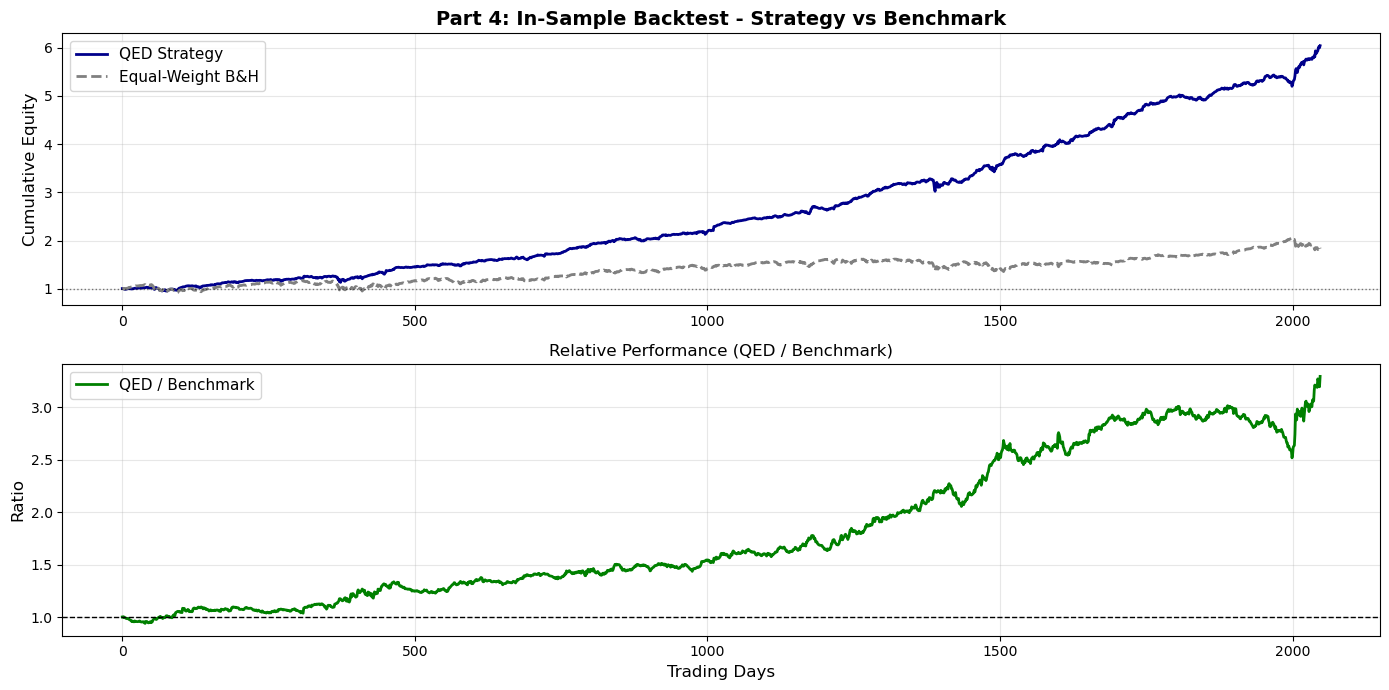

In [ ]:
# --- CELL: 31 In-Sample Return Backtest w Kramers Gate ---
# Vol-scale (Kelly)
barrier_mask = np.array(bar_pass_VAM, dtype=float)
long_mask = tf.cast(w_tilde > 0, dtype=tf.float32) 
kg_mask = long_mask * barrier_mask + (1 - long_mask)
w_tilde_kg = w_tilde * kg_mask

# Risk parity
w_risk_kg = w_tilde_kg / s_test

# Normalize
denom_kg = np.sum(np.abs(w_risk_kg), axis=1, keepdims=True)
denom_kg = np.where(denom_kg < 1e-10, 1.0, denom_kg)
positions_kg = w_risk_kg / denom_kg

# Leverage constraint
gross_kg = np.sum(np.abs(positions_kg), axis=1, keepdims=True)
scale_kg = np.where(gross_kg > max_leverage, max_leverage / gross_kg, 1.0)
positions_kg = positions_kg * scale_kg

# --- QED Strategy Returns ---
pflio_rets_kg = np.sum(positions_kg[:-1, :] * log_S_rets, axis=1)
equity_curve_kg = np.cumprod(1 + pflio_rets_kg)
fin_return_kg = equity_curve_kg[-1] - 1

# QED Strategy
ann_return_kg = (1 + fin_return_kg)**(ann_factor / len(pflio_rets_kg)) - 1
sharpe_kg = np.sqrt(ann_factor) * np.mean(pflio_rets_kg) / np.std(pflio_rets_kg)
max_dd_kg = np.min(equity_curve_kg / np.maximum.accumulate(equity_curve_kg) - 1)
turnover_kg = np.mean(np.sum(np.abs(np.diff(positions_kg, axis=0)), axis=1))

# Long/Short Exposure
long_exp_kg = np.mean(np.sum(np.where(positions_kg > 0, positions_kg, 0), axis=1))
short_exp_kg = np.mean(np.sum(np.where(positions_kg < 0, np.abs(positions_kg), 0), axis=1))

# --- Benchmark: Equal-Weight Buy-and-Hold ---
benchmark_returns = np.mean(log_S_rets, axis=1)
benchmark_equity = np.cumprod(1 + benchmark_returns)
benchmark_total_return = benchmark_equity[-1] - 1

# Benchmark
benchmark_ann_return = (1 + benchmark_total_return)**(ann_factor / len(benchmark_returns)) - 1
benchmark_sharpe = np.sqrt(ann_factor) * np.mean(benchmark_returns) / np.std(benchmark_returns)
benchmark_max_dd = np.min(benchmark_equity / np.maximum.accumulate(benchmark_equity) - 1)


# --- Display Results ---

print("------ PART 4: IN-SAMPLE RETURN BACKTEST - Kramers Gate ------")


print(f"\n{'Metric':<30} {'QED Strategy':>15} {'Benchmark':>15}")
print("-" * 62)
print(f"{'Annualized Return':<30} {ann_return_kg:>14.2%} {benchmark_ann_return:>14.2%}")
print(f"{'Sharpe Ratio':<30} {sharpe_kg:>15.4f} {benchmark_sharpe:>15.4f}")
print(f"{'Max Drawdown':<30} {max_dd_kg:>14.2%} {benchmark_max_dd:>14.2%}")
print(f"{'Total Return':<30} {fin_return_kg:>14.2%} {benchmark_total_return:>14.2%}")
print(f"{'Daily Turnover':<30} {turnover_kg:>15.4f} {'0.0000':>15}")
print(f"{'Avg Long Exposure':<30} {long_exp_kg:>14.2%} {'100.00%':>15}")
print(f"{'Avg Short Exposure':<30} {short_exp_kg:>14.2%} {'0.00%':>15}")

print(f"\n{'Excess Return (vs Benchmark)':<30} {(ann_return_kg - benchmark_ann_return):>14.2%}")
print(f"{'Sharpe Improvement':<30} {(sharpe_kg - benchmark_sharpe):>15.4f}")

# --- Plot Equity Curves ---
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(equity_curve_kg, linewidth=2, color='darkblue', label='QED Strategy')
plt.plot(benchmark_equity, linewidth=2, color='gray', linestyle='--', label='Equal-Weight B&H')
plt.axhline(y=1.0, color='black', linestyle=':', linewidth=1, alpha=0.5)
plt.title("Part 4: In-Sample Backtest - Strategy vs Benchmark", fontsize=14, fontweight='bold')
plt.ylabel("Cumulative Equity", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=11)

plt.subplot(2, 1, 2)
relative_perf = equity_curve_kg / benchmark_equity
plt.plot(relative_perf, linewidth=2, color='green', label='QED / Benchmark')
plt.axhline(y=1.0, color='black', linestyle='--', linewidth=1)
plt.title("Relative Performance (QED / Benchmark)", fontsize=12)
plt.xlabel("Trading Days", fontsize=12)
plt.ylabel("Ratio", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()

In [45]:
# --- CELL 32: Out-of-Sample Returns Backtest Calibration  ---
# --- Data Prep ---
T = log_S_rets.shape[0]
split = int(0.7 * T)
train_slice = slice(0, split)
test_slice  = slice(split, T)

# Training Data
x_ostrain = x_t[train_slice, :]
z1_ostrain = z1_t[train_slice, :]
z2_ostrain = z2_t[train_slice, :]
z3_ostrain = z3_t[train_slice, :]
log_S_rets_ostrain = log_S_rets[train_slice, :]

# Variable Re-initializations
k_ostrain = tf.Variable(tf.random.uniform([num_stocks], minval=-0.1, maxval=0.1), name="kappa_oos")
s_ostrain = tf.Variable(tf.random.uniform([num_stocks], minval=-0.1, maxval=0.1), name="sigma_oos")
t_ostrain = tf.Variable(tf.random.uniform([num_stocks], minval=-0.01, maxval=0.01), name="theta_oos")
g_ostrain = tf.Variable(tf.random.uniform([num_stocks], minval=0.0, maxval=0.00001), name="g_oos")
w_logits_oos = tf.Variable(tf.random.normal([num_stocks, 3], mean=0.0, stddev=0.1), name="w_logits_oos")

# Training 
print(f"Training OOS Returns Backtest on first {split} days...")
optimizer_oos = tf.keras.optimizers.Adam(learning_rate=0.0001)
for i in range(6001):
    with tf.GradientTape() as tape:
        # Log Returns
        log_x = tf.math.log(x_ostrain)
        log_x_next = tf.math.log(tf.roll(x_ostrain, shift=-1, axis=0))
        dy = log_x_next - log_x
    
        # Signals
        z1_log = tf.math.log(1.0 + z1_ostrain)
        z2_log = tf.math.log(1.0 + z2_ostrain)
        z3_log = z3_ostrain #VAM as drift term

        # Weighted Signal Returns
        W1 = w_logits_oos[:, 0]
        W2 = w_logits_oos[:, 1]
        W3 = w_logits_oos[:, 2]
        wtd_rets = W1 * z1_log + W2 * z2_log + W3 * z3_log

        # QED Model Drift: (theta - 0.5*sigma^2) - kappa*X - g*X^2
        exp_dy = (t_ostrain - 0.5 * tf.square(s_ostrain) + wtd_rets) - k_ostrain * tf.exp(log_x) - g_ostrain * tf.exp(2.0 * log_x)
        
        # Residuals
        v_res = (dy - exp_dy)[:-1, :]
        
        # Gaussian Negative Log-Likelihood
        sq_dist = tf.reduce_sum(tf.square(v_res / s_ostrain))
        T_eff = tf.cast(tf.shape(v_res)[0], tf.float32)
        log_det = T_eff * tf.reduce_sum(tf.math.log(tf.square(s_ostrain)))
        
        NLL = 0.5 * (sq_dist + log_det)
        
    # Optimize
    gradients = tape.gradient(NLL, [t_ostrain, k_ostrain, s_ostrain, g_ostrain, w_logits_oos])
    optimizer_oos.apply_gradients(zip(gradients, [t_ostrain, k_ostrain, s_ostrain, g_ostrain, w_logits_oos]))

    if i % 1000 == 0:
        print(f"Epoch {i}: Loss = {NLL.numpy():.6f}")

# --- Signal Contribution Analysis (VAM) ---
W1_oos = w_logits_oos[:, 0]
W2_oos = w_logits_oos[:, 1]
W3_oos = w_logits_oos[:, 2]

z1_oos = tf.math.log(1.0 + z1_ostrain)
z2_oos = tf.math.log(1.0 + z2_ostrain)
z3_oos = z3_ostrain

ma10_cont_oos = W1_oos * z1_oos
ma30_cont_oos = W2_oos * z2_oos
vam_cont_oos = W3_oos * z3_oos

print(f"\nSignal Contribution Analysis (Out-of-Sample Test):")
print(f"MA10 contribution std:  {tf.math.reduce_std(ma10_cont_oos).numpy():.6f}")
print(f"MA30 contribution std:  {tf.math.reduce_std(ma30_cont_oos).numpy():.6f}")
print(f"VAM contribution std: {tf.math.reduce_std(vam_cont_oos).numpy():.6f}")

print("Done.")


Training OOS Returns Backtest on first 1433 days...
Epoch 0: Loss = 31918.140625
Epoch 1000: Loss = -162899.781250
Epoch 2000: Loss = -163215.828125
Epoch 3000: Loss = -163299.250000
Epoch 4000: Loss = -163323.875000
Epoch 5000: Loss = -163338.078125
Epoch 6000: Loss = -163347.187500

Signal Contribution Analysis (Out-of-Sample Test):
MA10 contribution std:  0.000595
MA30 contribution std:  0.000494
VAM contribution std: 0.000584
Done.


In [40]:
# --- CELL 33: Out-of-Sample Returns Backtest Kramers r ---
t_val_oos = t_ostrain.numpy()
k_val_oos = k_ostrain.numpy()
s_val_oos = s_ostrain.numpy()
g_val_oos = g_ostrain.numpy()

r_oos = []
bar_pass_oos = []

for i in range(num_stocks):
    t, k, s, g_val = t_val_oos[i], k_val_oos[i], s_val_oos[i], g_val_oos[i]
    alpha = t - 0.5 * s**2
    
    # Critical Points: g*u^2 + k*u - alpha = 0
    u_roots = np.roots([g_val, k, -alpha])
    u_real = u_roots[np.isreal(u_roots)].real
    u_pos = sorted(u_real[u_real > 0])
    
    pass_test = False
    
    if len(u_pos) == 2:
        u_1, u_2 = u_pos[0], u_pos[1]
        v_pp_1 = k * u_1 + 2 * g_val * u_1**2
        v_pp_2 = k * u_2 + 2 * g_val * u_2**2

        if (v_pp_1 * v_pp_2) < 0:
            u_min = u_1 if v_pp_1 > 0 else u_2
            u_max = u_2 if v_pp_1 > 0 else u_1
            y_min_val, y_bar_val = np.log(u_min), np.log(u_max)
            
            V = lambda y: -alpha * y + k * np.exp(y) + 0.5 * g_val * np.exp(2 * y)
            delta_V = V(y_bar_val) - V(y_min_val)
            # Kramers Rate
            if delta_V > 0:
                curv_min = k * u_min + 2 * g_val * u_min**2
                curv_max = k * u_max + 2 * g_val * u_max**2
                prefactor = np.sqrt(curv_min * abs(curv_max)) / (2 * np.pi)
                r_val = prefactor * np.exp(-delta_V / (s**2))
                pass_test = delta_V > 3 * (s**2) / 2
    
    r_oos.append(r_val)
    bar_pass_oos.append(pass_test)

# Convert to a mask for the test slice
bar_mask_oos = np.array(bar_pass_oos).astype(float) # Shape: (num_stocks,)
print(f"OOS Kramers Analysis Complete. Stocks passing: {np.sum(bar_mask_oos)}")

OOS Kramers Analysis Complete. Stocks passing: 13.0


In [69]:
# --- CELL 34: Out-of-Sample Returns Backtest  ---

# Calibrated Parameters
t_ostest = t_ostrain.numpy()
k_ostest = k_ostrain.numpy()
s_ostest = s_ostrain.numpy()
g_ostest = g_ostrain.numpy()
w_ostest = w_logits_oos.numpy()

# Weights
W1_ostest = w_ostest[:, 0]
W2_ostest = w_ostest[:, 1]
W3_ostest = w_ostest[:, 2]

# Tensors
xt_S_ostest = x_t.numpy()[test_slice]
z1_ostest = z1_log_VAM.numpy()[test_slice]
z2_ostest = z2_log_VAM.numpy()[test_slice]
z3_ostest = z3_log_VAM.numpy()[test_slice]

# Compute log returns
log_xt_S = np.log(xt_S_ostest)
log_S_rets_ostest = log_S_rets[test_slice]

# --- Inferred Drift μ_t ---
wtd_rets_oos = (W1_ostest * z1_ostest + W2_ostest * z2_ostest + W3_ostest * z3_ostest)
base_drift_oos = t_ostest - 0.5 * s_ostest**2
Mean_rev_oos = -k_ostest * log_xt_S - g_ostest * (log_xt_S**2)
mu_t_oos = base_drift_oos + wtd_rets_oos + Mean_rev_oos

# --- Position Sizing ---
# Vol-scale (Kelly scaled)
w_tilde_oos = mu_t_oos / (s_ostest**2)

# Barrier Mask
bar_mask_oos = np.array(bar_pass_oos, dtype=float)
long_mask_oos = (w_tilde_oos > 0).astype(float)
kg_mask_oos = long_mask_oos * bar_mask_oos + (1 - long_mask_oos)
w_tilde_kg_oos = w_tilde_oos * kg_mask_oos

# Risk parity
w_risk_oos = w_tilde_kg_oos / s_ostest

# Normalize
denom_oos = np.sum(np.abs(w_risk_oos), axis=1, keepdims=True)
denom_oos = np.where(denom_oos < 1e-10, 1.0, denom_oos)
positions_oos = w_risk_oos / denom_oos

# Leverage constraint
gross_oos = np.sum(np.abs(positions_oos), axis=1, keepdims=True)
scale_oos = np.where(gross_oos > max_leverage, max_leverage / gross_oos, 1.0)
positions_oos = positions_oos * scale_oos

# --- QED Strategy Returns ---
pflio_rets_oos = np.sum(positions_oos[:-1] * log_S_rets_ostest[1:], axis=1)
equity_curve_oos = np.cumprod(1 + pflio_rets_oos)
final_ret_oos = equity_curve_oos[-1] - 1

# --- Metrics ---
ann_return_oos = (1 + final_ret_oos)**(ann_factor / len(pflio_rets_oos)) - 1
sharpe_oos = np.sqrt(ann_factor) * np.mean(pflio_rets_oos) / np.std(pflio_rets_oos)
max_dd_oos = np.min(equity_curve_oos / np.maximum.accumulate(equity_curve_oos) - 1)
turnover_oos = np.mean(np.sum(np.abs(np.diff(positions_oos, axis=0)), axis=1))

long_exp_oos = np.mean(np.sum(np.where(positions_oos > 0, positions_oos, 0), axis=1))
short_exp_oos = np.mean(np.sum(np.where(positions_oos < 0, -positions_oos, 0), axis=1))

# --- Benchmark ---
bench_rets_oos = np.mean(log_S_rets_ostest[1:], axis=1)
bench_eq_oos = np.cumprod(1 + bench_rets_oos)
bench_ret_oos = bench_eq_oos[-1] - 1
bench_ann_oos = (1 + bench_ret_oos)**(ann_factor / len(bench_rets_oos)) - 1
bench_sharpe_oos = np.sqrt(ann_factor) * np.mean(bench_rets_oos) / np.std(bench_rets_oos)
bench_dd_oos = np.min(bench_eq_oos / np.maximum.accumulate(bench_eq_oos) - 1)

# --- Output ---
print("------ PART 5: OUT-OF-SAMPLE BACKTEST ------\n")
print(f"{'Metric':<30} {'QED Strategy':>15} {'Benchmark':>15}")
print("-" * 62)
print(f"{'Annualized Return':<30} {ann_return_oos:>14.2%} {bench_ann_oos:>14.2%}")
print(f"{'Sharpe Ratio':<30} {sharpe_oos:>15.4f} {bench_sharpe_oos:>15.4f}")
print(f"{'Max Drawdown':<30} {max_dd_oos:>14.2%} {bench_dd_oos:>14.2%}")
print(f"{'Total Return':<30} {final_ret_oos:>14.2%} {bench_ret_oos:>14.2%}")
print(f"{'Daily Turnover':<30} {turnover_oos:>15.4f} {'0.0000':>15}")
print(f"{'Avg Long Exposure':<30} {long_exp_oos:>14.2%} {'100.00%':>15}")
print(f"{'Avg Short Exposure':<30} {short_exp_oos:>14.2%} {'0.00%':>15}")

------ PART 5: OUT-OF-SAMPLE BACKTEST ------

Metric                            QED Strategy       Benchmark
--------------------------------------------------------------
Annualized Return                      -0.42%          7.33%
Sharpe Ratio                           -0.0619          0.6473
Max Drawdown                           -7.49%        -13.24%
Total Return                           -1.01%         18.81%
Daily Turnover                          0.0361          0.0000
Avg Long Exposure                      55.97%         100.00%
Avg Short Exposure                     44.03%           0.00%


In [70]:
print(f"Mean wtd_rets: {np.mean(np.abs(wtd_rets_oos))}")
print(f"Mean Mean_rev: {np.mean(np.abs(Mean_rev_oos))}")
print(f"Mean base_drift: {np.mean(np.abs(base_drift_oos))}")

Mean wtd_rets: 0.0004850982513744384
Mean Mean_rev: 0.02683713659644127
Mean base_drift: 0.011431774124503136
